In [92]:
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.pbh import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.integrate
import numba
import pickle
import tqdm


In [2]:
import emcee
import corner

In [3]:
%matplotlib inline
%config InlineBackend.figure_format=''
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 150

In [4]:
ds=8

In [5]:
l=0
b=0
m_lens = 1
pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds)
ts = np.logspace(1,4,50)

In [6]:
pbh.l=00
pbh.b=00

In [7]:

result_mw = [pbh.differential_rate_mw(t, finite=False) for t in ts]

/Users/duncan/mambaforge/envs/science/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/duncan/mambaforge/envs/science/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be use

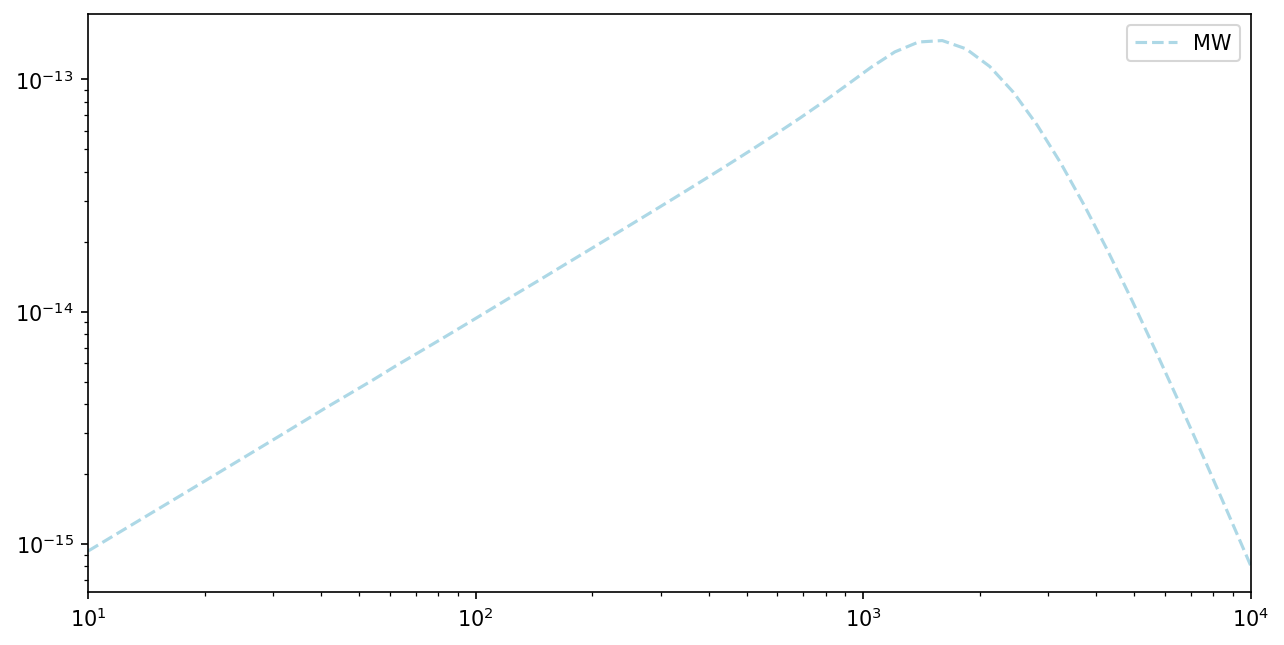

In [8]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.xlim(np.min(ts), np.max(ts))
# plt.ylim(1e-8, 1e-5)""
plt.legend()
plt.show()

In [9]:
print(pbh.differential_rate_integrand_lognorm(.5 ,7, 1000, 1, pbh.mw_model))

1.013263395663148e-14


In [10]:
# def sample_density(#l, # galactic longitude (degrees)
#                    #b, # galactic latitide (degrees)
#                    d  # lens distance from Earth (kpc)
# ):
#     #pbh.l = l
#     #pbh.b = b
#     d = d[0]
    # return 20+np.log(pbh.differential_rate_integrand_lognorm(.5 ,d, 1000, 1, pbh.mw_model))

In [80]:
def sample_density_log(params, # galactic longitude (degrees)
                     # b, # galactic latitide (degrees)
                     # dl,  # lens distance from Earth (kpc)
                     # ds,  # source distance from Earth (kpc)
                     this_pbh, # LensCalcPy.pbh object
                     lbounds=(-10,10),
                     bbounds=(-10,10),
                     #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    this_pbh.l, this_pbh.b, dl, this_pbh.ds, umin, crossing_time = params
    if this_pbh.l < lbounds[0] \
    or this_pbh.l > lbounds[1] \
    or this_pbh.b > bbounds[1] \
    or this_pbh.b < bbounds[0] \
    or dl < 0 or dl > this_pbh.ds \
    or umin <= 0 \
    or crossing_time <= 0:
        return -np.inf
    prob = this_pbh.differential_rate_integrand(umin ,dl, crossing_time, this_pbh.mw_model)
    # multiply by expected number of stars in volume element 
    prob *= this_pbh.ds**2 * np.cos(this_pbh.b*np.pi/180) * \
            this_pbh.mw_model.density_stars(this_pbh.ds, \
                                            this_pbh.l,  \
                                            this_pbh.b)
    if prob <= 0 or np.isnan(prob):
        return -np.inf
    return np.log(prob)

def sample_density(params, # galactic longitude (degrees)
                 # b, # galactic latitide (degrees)
                 # dl,  # lens distance from Earth (kpc)
                 # ds,  # source distance from Earth (kpc)
                 this_pbh, # LensCalcPy.pbh object
                 lbounds=(-10,10),
                 bbounds=(-10,10),
                 #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    this_pbh.l, this_pbh.b, dl, this_pbh.ds, umin, crossing_time = params
    if this_pbh.l < lbounds[0] \
    or this_pbh.l > lbounds[1] \
    or this_pbh.b > bbounds[1] \
    or this_pbh.b < bbounds[0] \
    or dl < 0 or dl > this_pbh.ds \
    or umin <= 0 \
    or crossing_time <= 0:
        return 0
    prob = this_pbh.differential_rate_integrand(umin ,dl, crossing_time, this_pbh.mw_model)
    # multiply by expected number of stars in volume element 
    expected_stars = (np.pi/180)**2 * this_pbh.ds**2 * np.cos(this_pbh.b*np.pi/180) * \
            this_pbh.mw_model.density_stars(this_pbh.ds, \
                                            this_pbh.l,  \
                                            this_pbh.b) 
    prob*=expected_stars   
    if prob < 0 or np.isnan(prob):
        print(f"error: expected stars = {expected_stars}")
        print(f"density: {this_pbh.mw_model.density_stars(this_pbh.ds, this_pbh.l, this_pbh.b) }")
        print(f"cos(b): {np.cos(this_pbh.b)}")
        return 0
    return prob

def sample_density_log(params, # galactic longitude (degrees)
                     # b, # galactic latitide (degrees)
                     # dl,  # lens distance from Earth (kpc)
                     # ds,  # source distance from Earth (kpc)
                     this_pbh, # LensCalcPy.pbh object
                     lbounds=(-10,10),
                     bbounds=(-10,10),
                     #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    return np.log(sample_density())

Units for the above:
'differential_rate_integrand' is in $(\text{h})^{-2} (\text{kpc})^{-1}$.
'density_stars' is in $(\text{kpc})^{-3} M_\odot$

So, integrate over observing time, event time, observing volume and line of sight to get expected number of events?

Idea: take average of $\text{rate}(\text{events})/\text{kde}(\text{events})$ to get integrated event rate


8.1998199819982

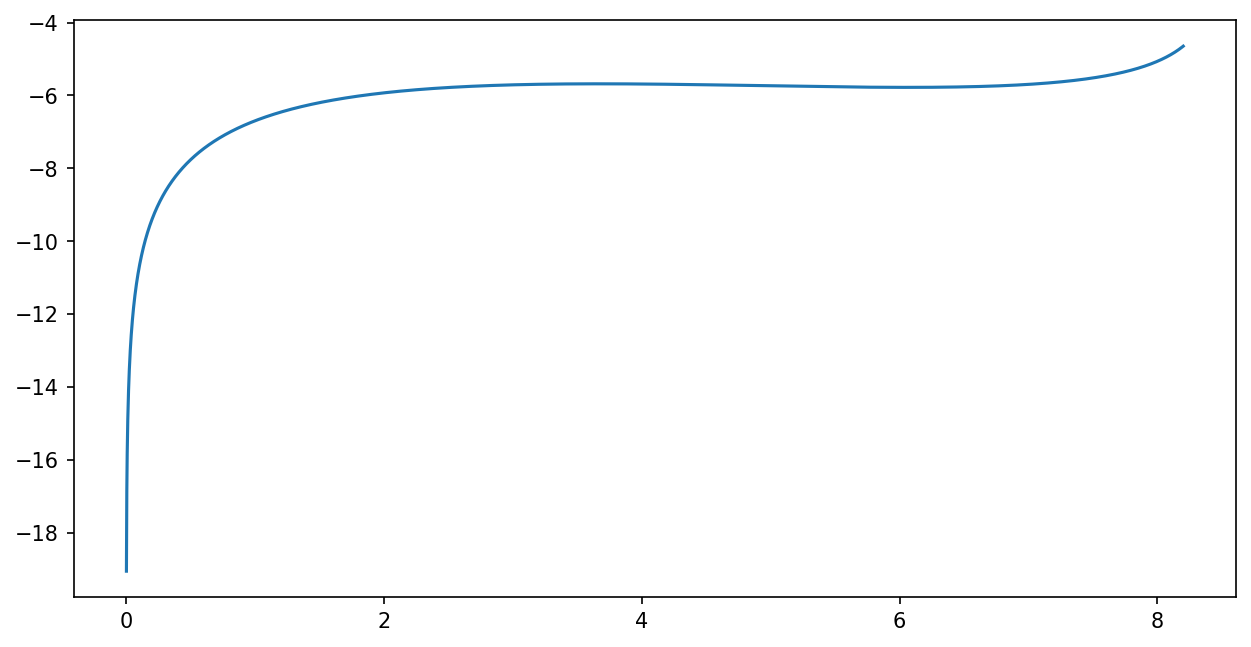

In [12]:
xs = np.linspace(0,15,10**4)
ys = [sample_density_log([0,0,x,8.2,.5, 1000], pbh) for x in xs]
plt.plot(xs,ys)
xs[np.argmax(ys)]

In [13]:
with open('eventsamples.pkl', 'rb') as eventsamples:
    exsamples = pickle.load(eventsamples)

In [235]:
ndims = 6
nwalkers = 12

sampler = emcee.EnsembleSampler(nwalkers,ndims,sample_density_log, args=[pbh, (-90,90),(-45,45)])

In [16]:
ndims = 6
nwalkers = 20

sampler10x10 = emcee.EnsembleSampler(nwalkers,ndims,sample_density_log, args=[pbh, (-10,10),(-10,10)])

In [17]:
# p0 = np.array((0,0,7.5,8,.5, 100)) + (np.random.rand(nwalkers, ndims)-.5)/[1,1,2,2,2,1/800]

In [163]:
p0 = exsamples[np.random.choice(exsamples.shape[0], size=nwalkers, replace=False)]


In [19]:
p0_10x10 = exsamples[np.random.choice(exsamples.shape[0], size=nwalkers, replace=False)]


In [236]:
for i,p in enumerate(p0):
    this_prob = sample_density_log(p, pbh)
    while np.isinf(this_prob):
        p0[i] = exsamples[np.random.choice(exsamples.shape[0], size=1)]
        this_prob = sample_density_log(p, pbh)
    print(f'{p0[i]}:{this_prob}')

[ 6.24992637e+00 -3.06806475e+00  8.17405478e+00  1.02699231e+01
  7.08601201e-01  1.73214479e+03]:-5.980323733352147
[-3.84900577e+00 -4.00502509e+00  7.16302622e+00  8.71025958e+00
  4.18039204e-01  1.81166576e+03]:-6.228316762515178
[9.80591804e+00 8.36794712e-02 7.27923984e+00 1.29681417e+01
 4.85994507e-02 2.93679146e+03]:-7.019916916317366
[6.08002906e-01 2.28573668e+00 8.48376774e+00 9.81499668e+00
 2.94364487e-01 3.46247411e+03]:-5.346126000946091
[-5.21024655e+00  3.86850619e-01  7.43829284e+00  8.52145805e+00
  3.90912241e-01  1.98406582e+03]:-5.552076629175583
[-6.78562565e+00  1.01629881e+00  8.10820955e+00  9.17682933e+00
  6.77133299e-01  1.74034731e+03]:-6.315412647746109
[1.84435220e+00 1.41173158e+00 8.09159349e+00 1.08077160e+01
 5.62356250e-01 1.93219272e+03]:-5.945879652487629
[6.93540935e-01 2.95134409e-01 8.64627271e+00 8.81229648e+00
 5.43106170e-01 4.11687891e+03]:-3.133524072625963
[-1.08839365e+00 -4.28668794e+00  7.40172314e+00  7.90050889e+00
  5.44856893e-0

In [135]:
for i,p in enumerate(p0_10x10):
    this_prob = sample_density_log(p, pbh)
    while np.isinf(this_prob):
        p0_10x10[i] = exsamples[np.random.choice(exsamples.shape[0], size=1)]
        this_prob = sample_density_log(p, pbh)
    print(f'{p0_10x10[i]}:{this_prob}')

NameError: name 'p0_10x10' is not defined

In [22]:
np.isinf(-np.inf)

True

In [239]:
sampler.sample?

Signature:
sampler.sample(
    initial_state,
    log_prob0=None,
    rstate0=None,
    blobs0=None,
    iterations=1,
    tune=False,
    skip_initial_state_check=False,
    thin_by=1,
    thin=None,
    store=True,
    progress=False,
    progress_kwargs=None,
)
Docstring:
Advance the chain as a generator

Args:
    initial_state (State or ndarray[nwalkers, ndim]): The initial
        :class:`State` or positions of the walkers in the
        parameter space.
    iterations (Optional[int or NoneType]): The number of steps to generate.
        ``None`` generates an infinite stream (requires ``store=False``).
    tune (Optional[bool]): If ``True``, the parameters of some moves
        will be automatically tuned.
    thin_by (Optional[int]): If you only want to store and yield every
        ``thin_by`` samples in the chain, set ``thin_by`` to an
        integer greater than 1. When this is set, ``iterations *
        thin_by`` proposals will be made.
    store (Optional[bool]): By defau

In [241]:
nsteps=210000
state = sampler.run_mcmc(p0,nsteps,)#, skip_initial_state_check=True)
samples = sampler.get_chain(flat=True, discard=10000)

In [97]:
with open(f"eventsamples_{len(samples)}.pkl", mode='wb') as samplefile:
    pickle.dump(samples, samplefile)

In [165]:
nsteps=110000
state = sampler10x10.run_mcmc(p0_10x10, nsteps, skip_initial_state_check=True)
samples10x10 = sampler10x10.get_chain(flat=True, discard=10000)

NameError: name 'sampler10x10' is not defined

In [310]:
samples[:,:2].T

array([[ -6.09582943,   1.25235929,   4.3477502 , ...,   8.78656505,
          4.68110252, -13.87958658],
       [ -6.23027868,  -1.25793493,   6.03449504, ...,   5.76811979,
          0.06745683,  -0.25625075]])

In [311]:
import pickle

In [312]:
# with open("eventsamples.pkl", mode='wb') as samplefile:
#     pickle.dump(samples, samplefile)

In [313]:
#density = gaussian_kde(samples[:,:2].T)(samples[:,:2].T)
#density = gaussian_kde(samples[:,:2].T)(samples[:,:2].T)
#density = density.reshape(samples[:,:2].T)

In [322]:
samples.shape
np.random.choice(n_subsample)

68184

In [619]:
n_subsample=10000

random_subset = samples[np.random.choice(samples.shape[0],size=n_subsample)][:,:2].T
#random_subset = samples[:,:2].T
kde = gaussian_kde(random_subset)
#kde.set_bandwidth(kde.factor)

density = kde(samples[:,:2].T)

In [336]:
xmax,ymax = np.max(samples[:,:2], axis=0)
xmin,ymin = np.min(samples[:,:2], axis=0)

np.sum(density)/(xmax-xmin)/(ymax-ymin)
np.sum(density)/len(samples)

0.007064925004187976

In [346]:
#kde.integrate_box((xmin, xmax),(ymin,ymax))
kde.integrate_box((-1, 1),(-1,1))


0.0

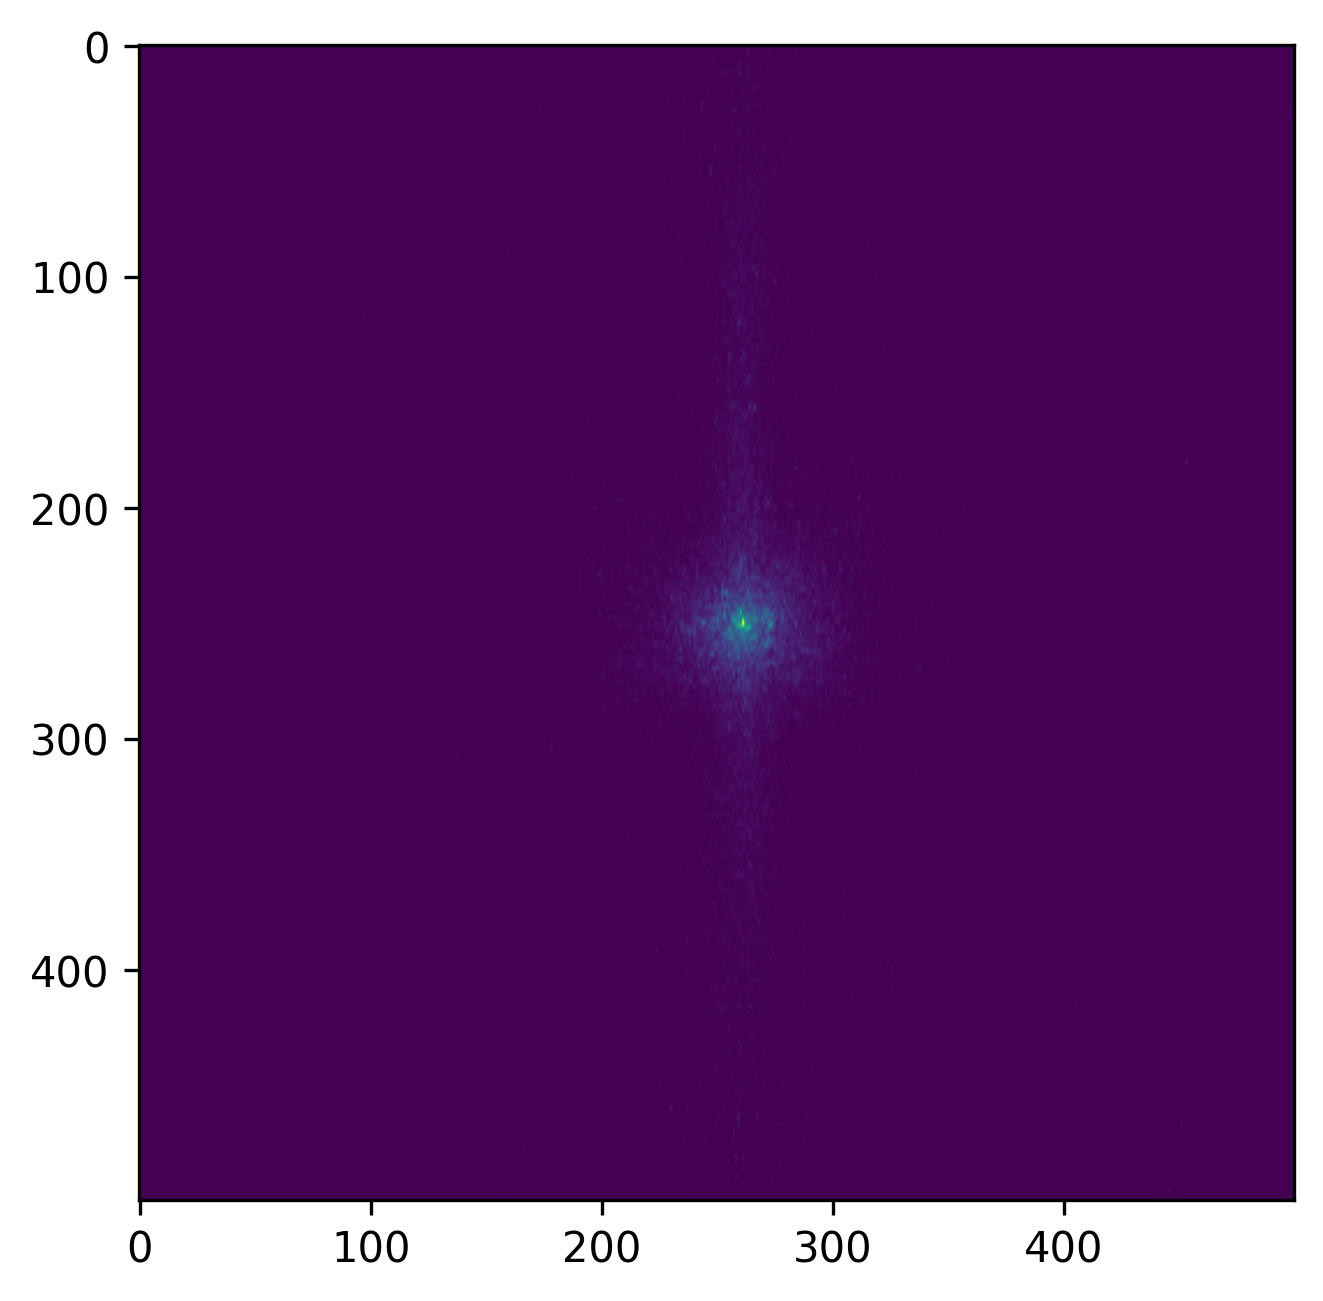

In [372]:
ngrid = 500
evenx = np.linspace(xmin,xmax,ngrid)
eveny = np.linspace(ymin,ymax,ngrid)
evengrid = np.array(np.meshgrid(evenx, eveny)).T.reshape(-1,2).T
evendensity = kde(evengrid).reshape(ngrid,ngrid)


/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_91795/1031796156.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.rot90(np.log(evendensity)),clim=(-10,0))


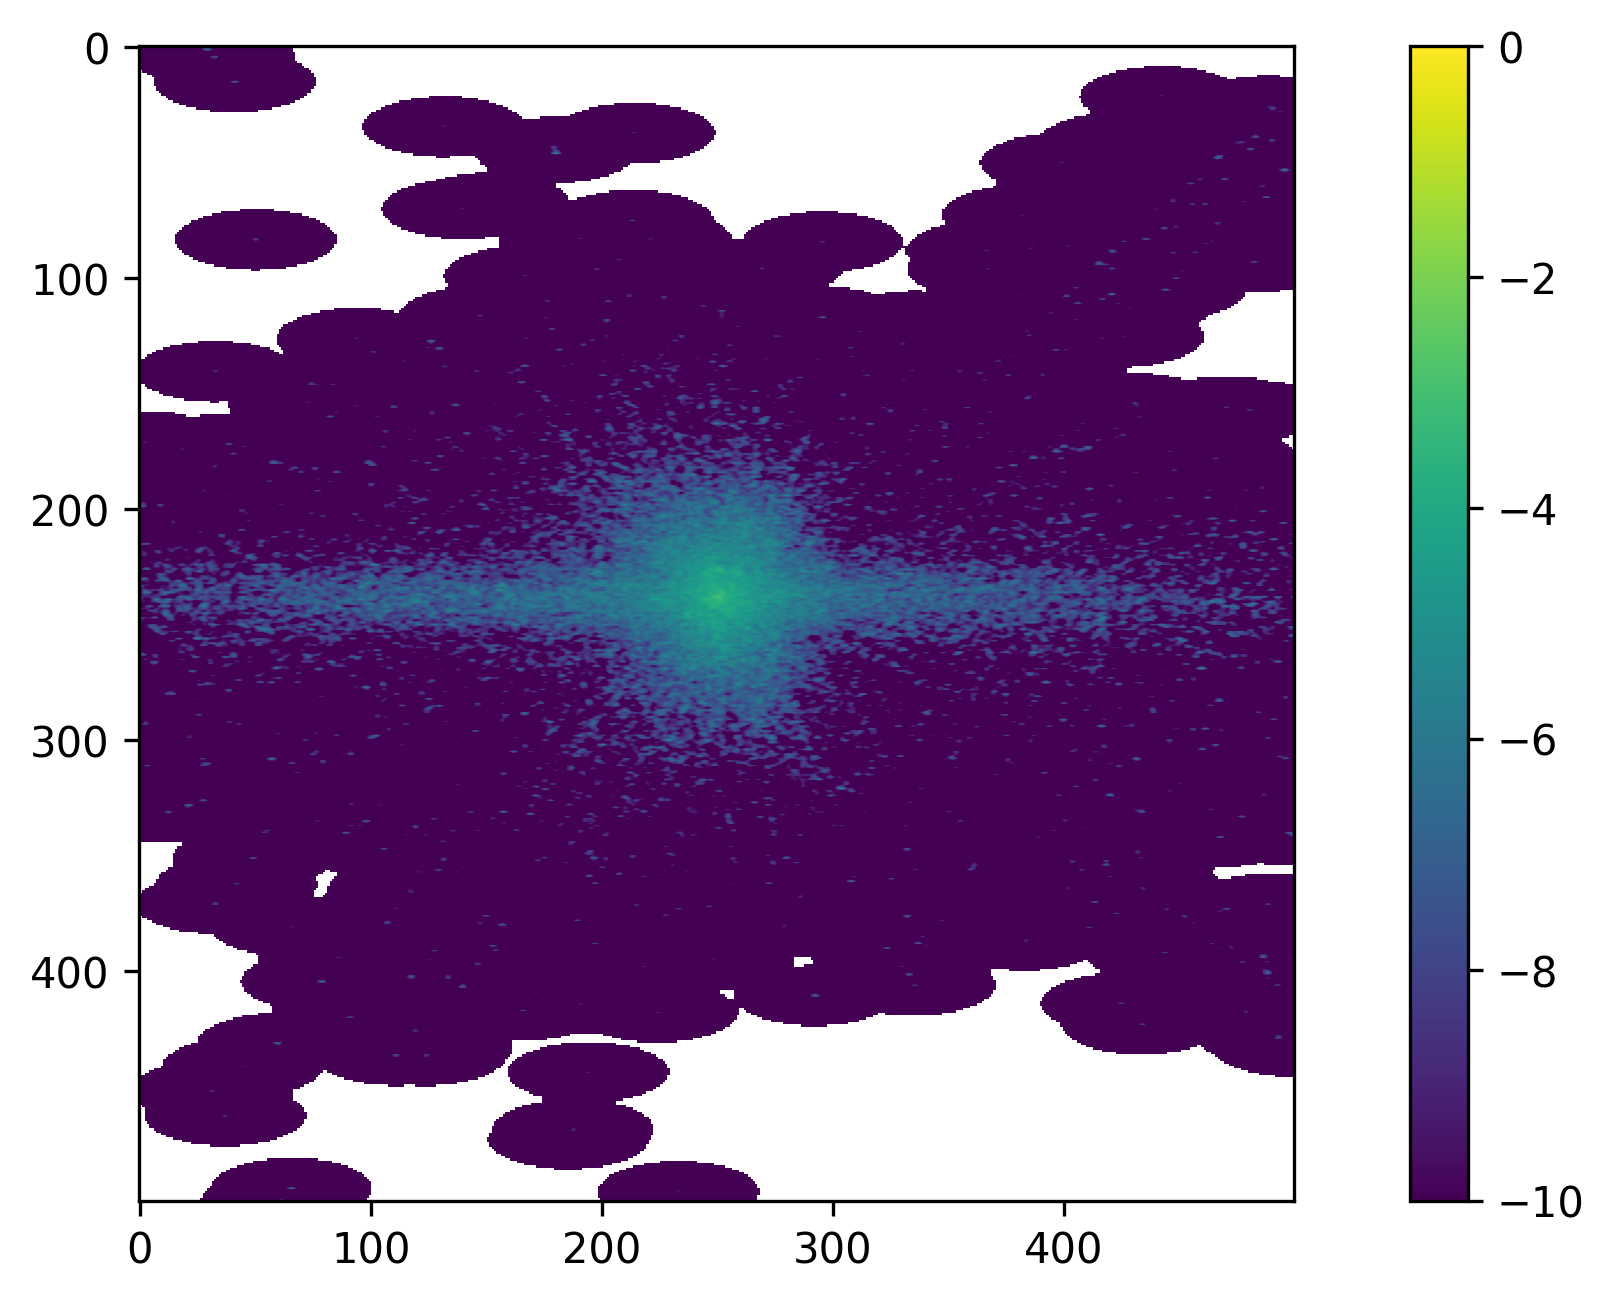

In [398]:
plt.imshow(np.rot90(np.log(evendensity)),clim=(-10,0))
cbar = plt.colorbar()


In [368]:
print(evengrid)
print(evendensity)

[[-49.97020588 -49.97020588 -49.97020588 ...  49.93658263  49.93658263
   49.93658263]
 [-33.01093511 -32.37177194 -31.73260878 ...  28.98789195  29.62705511
   30.26621828]]
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.58589506e-319
  2.00451619e-241 1.38344284e-199]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 5.02957024e-244
  5.46654647e-176 3.08808229e-135]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.10049105e-182
  2.13706765e-121 1.09479216e-083]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [339]:
(xmin, xmax),(ymin,ymax)

((-49.97020588370589, 49.93658263482423),
 (-33.01093510648802, 30.266218276088388))

In [334]:
np.max(samples[:,:2].T, axis=0)

array([-6.09582943,  1.25235929,  6.03449504, ...,  8.78656505,
        4.68110252, -0.25625075])

Text(0, 0.5, 'Galactic latitude b (degrees)')

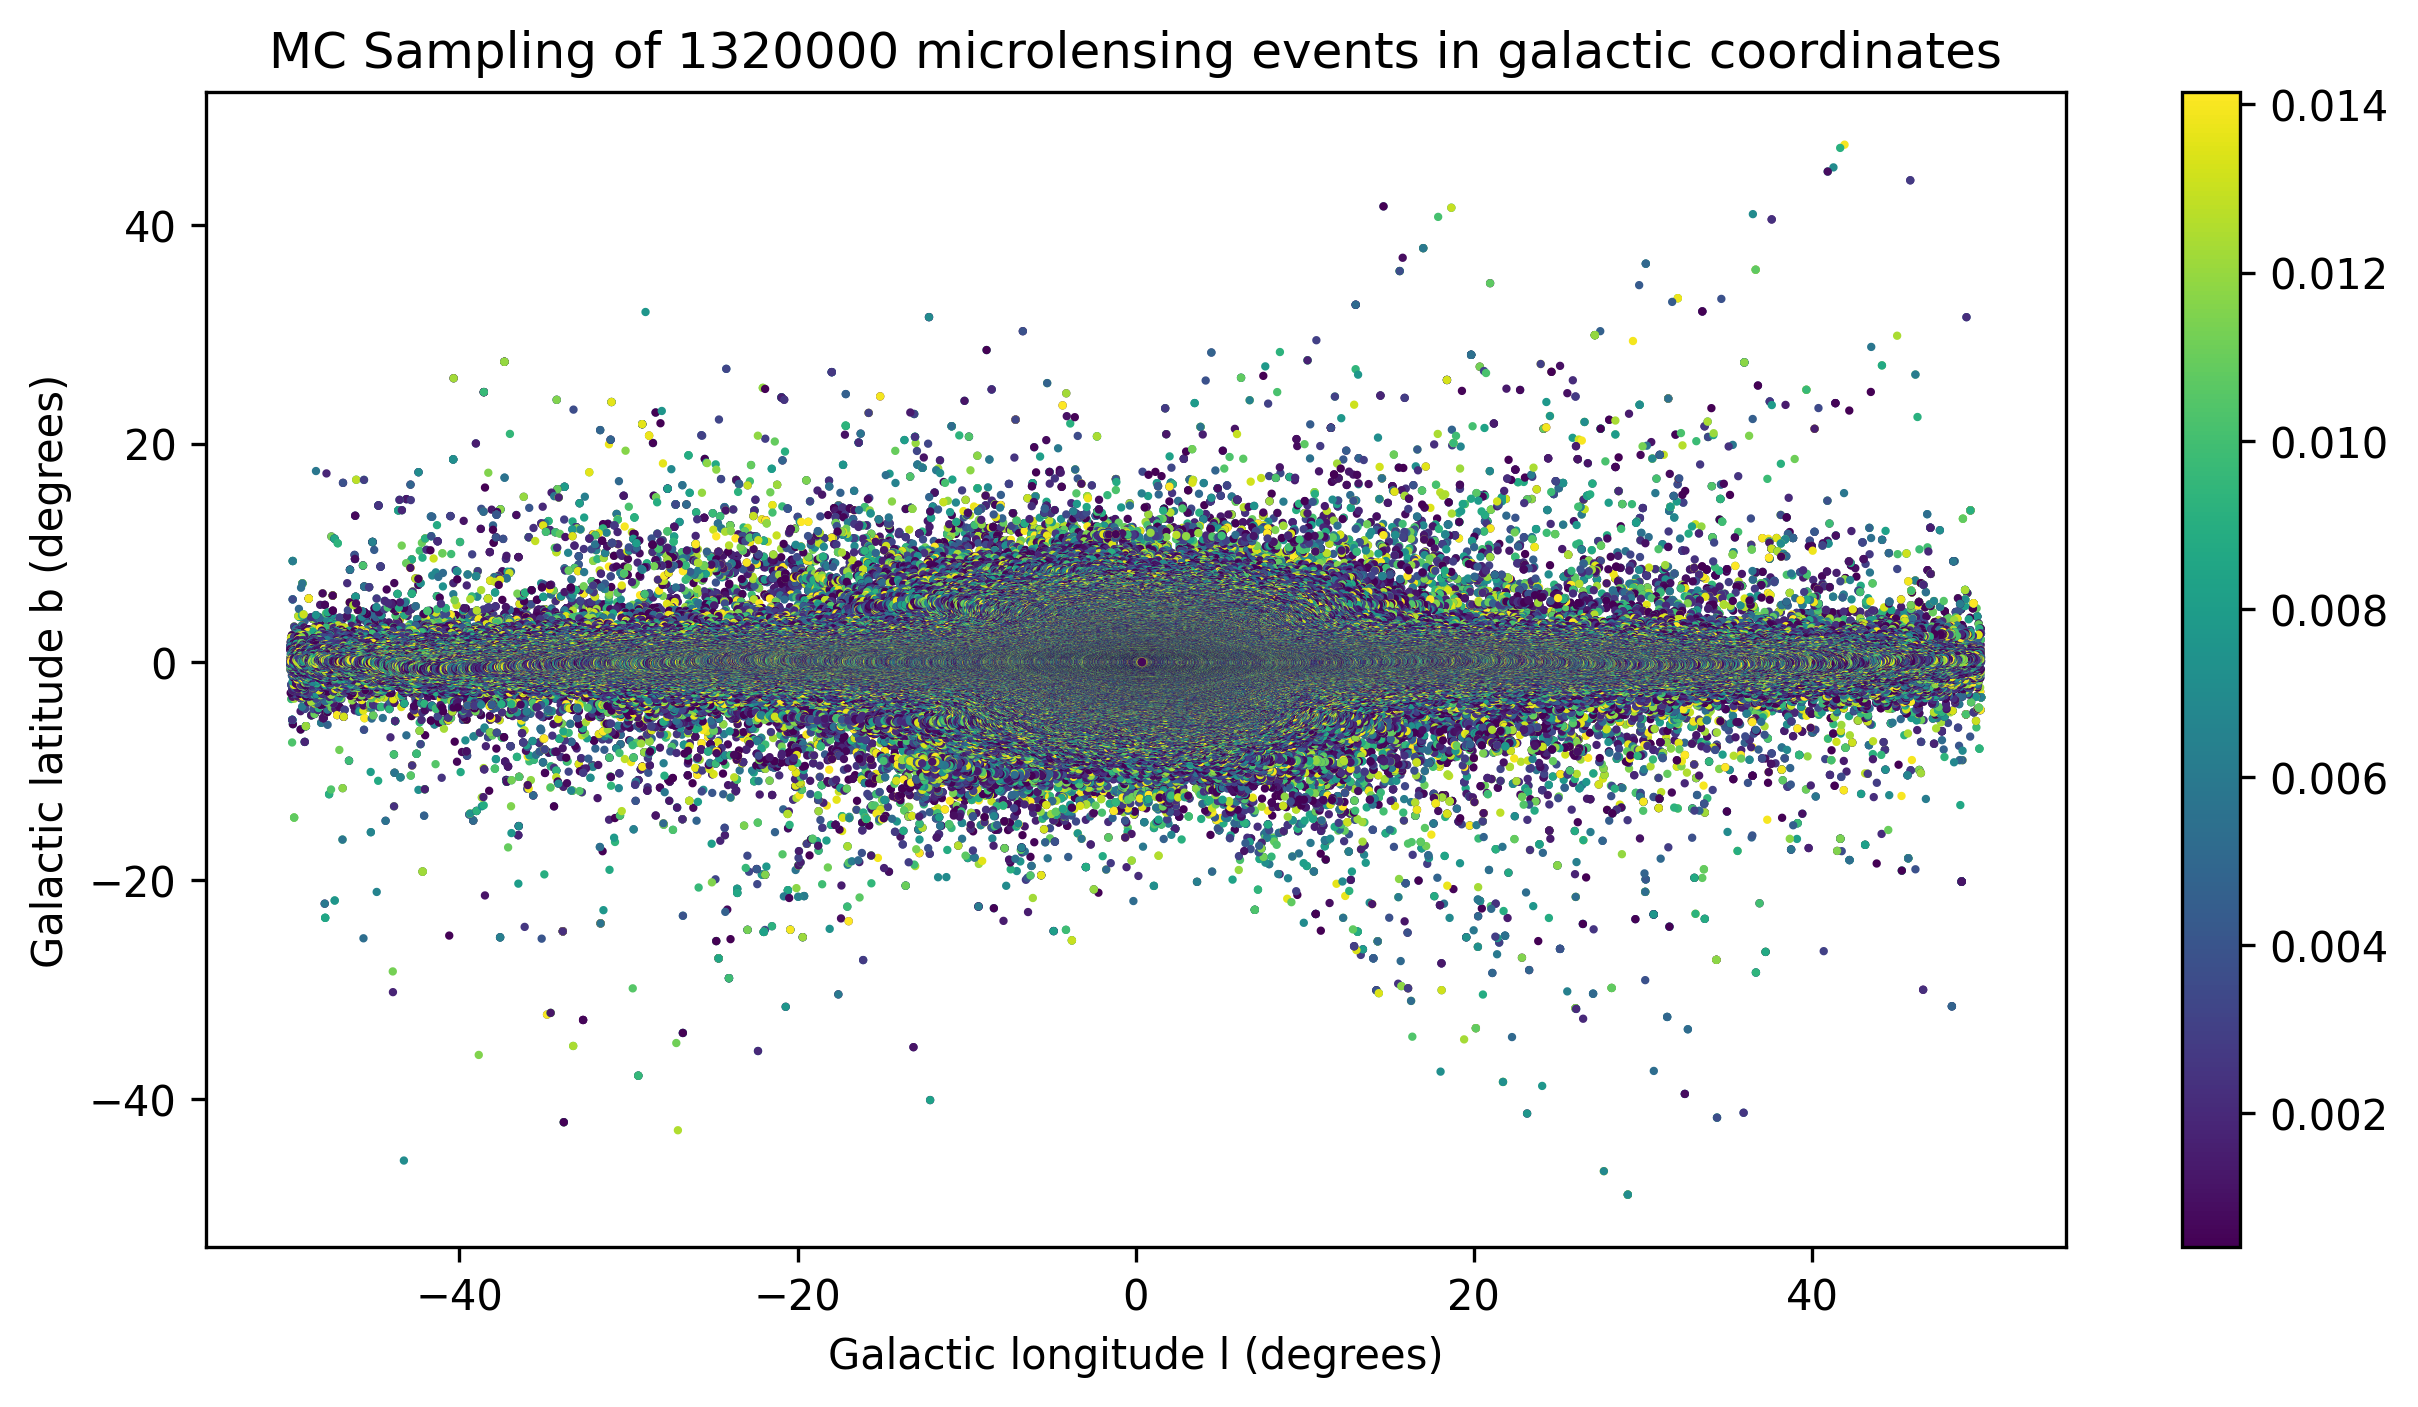

In [626]:

dsort = density.argsort()
x,y = samples[:,:2].T
x=x[dsort]
y=y[dsort]
logdensity =density
plt.scatter(x,y, c=logdensity,clim=np.percentile(logdensity, (10,99)),s=1)
plt.colorbar()
plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

Text(0, 0.5, 'Galactic latitude b (degrees)')

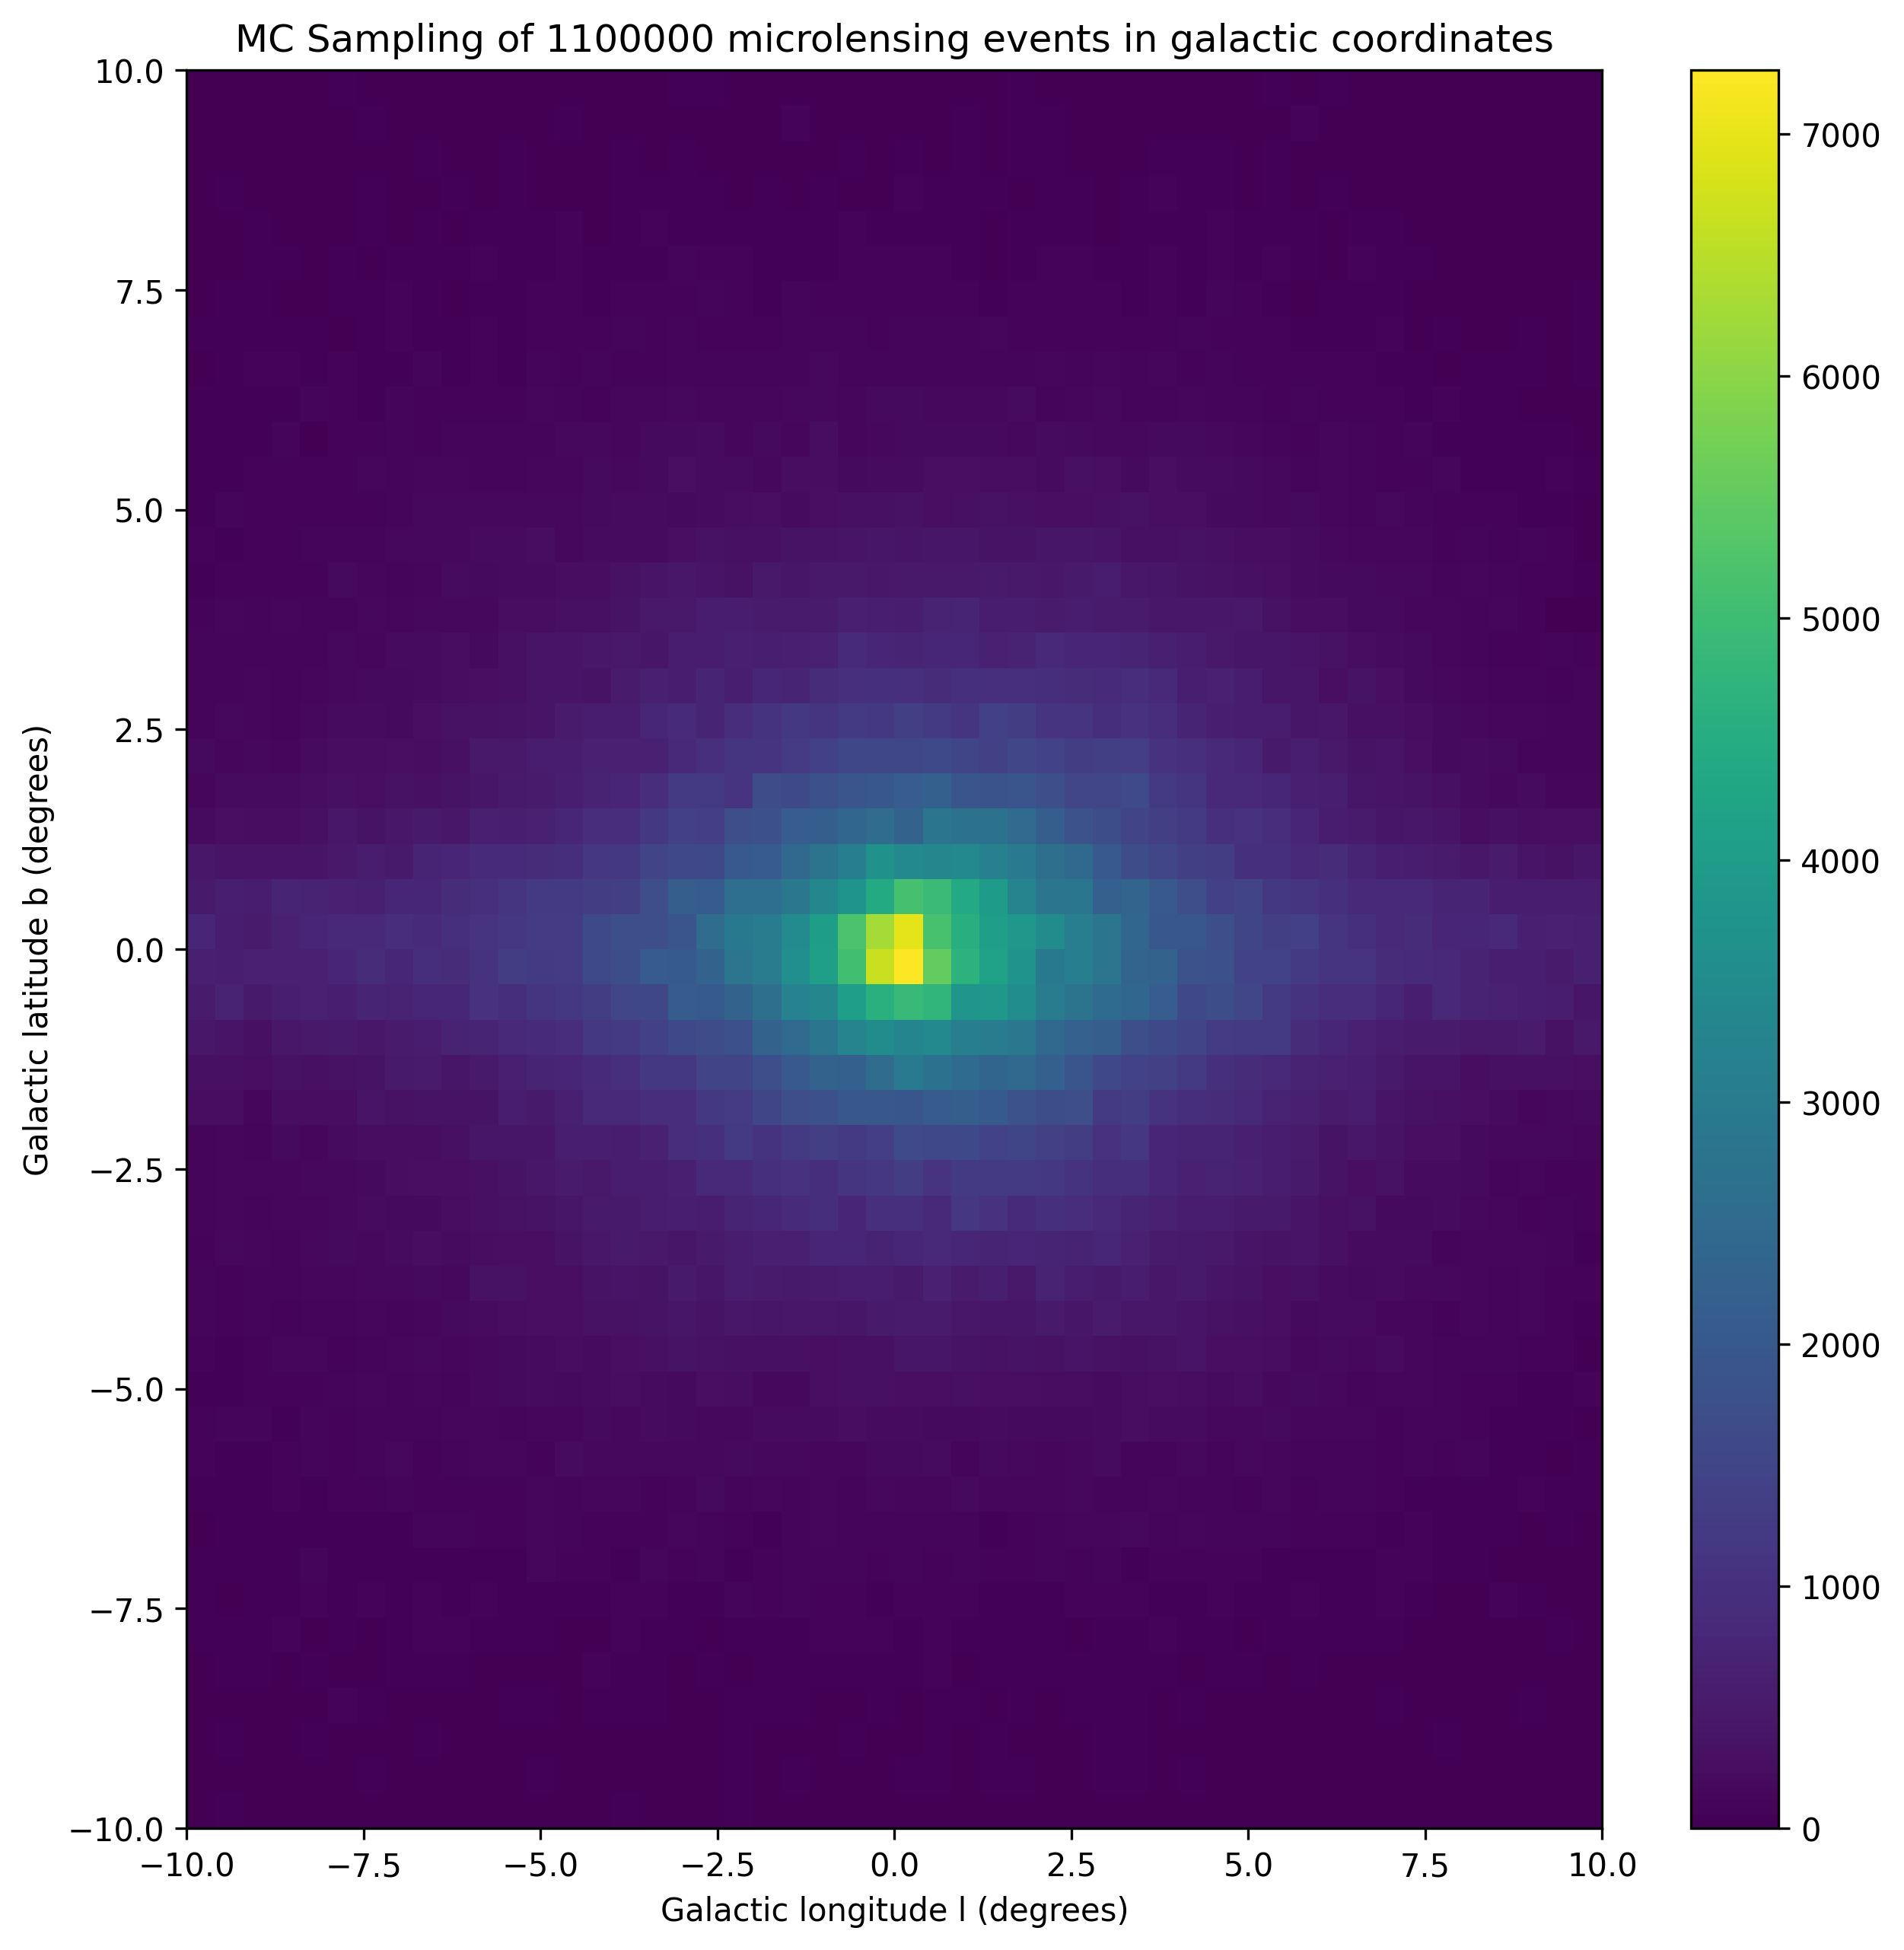

In [640]:
plt.subplots(figsize=(10,10))

plt.hist2d(*samples10x10[:,:2].T, bins=50, range=((-10,10),(-10,10)));
plt.colorbar()
plt.title(f'MC Sampling of {len(samples10x10)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')


Text(0, 0.5, 'Galactic latitude b (degrees)')

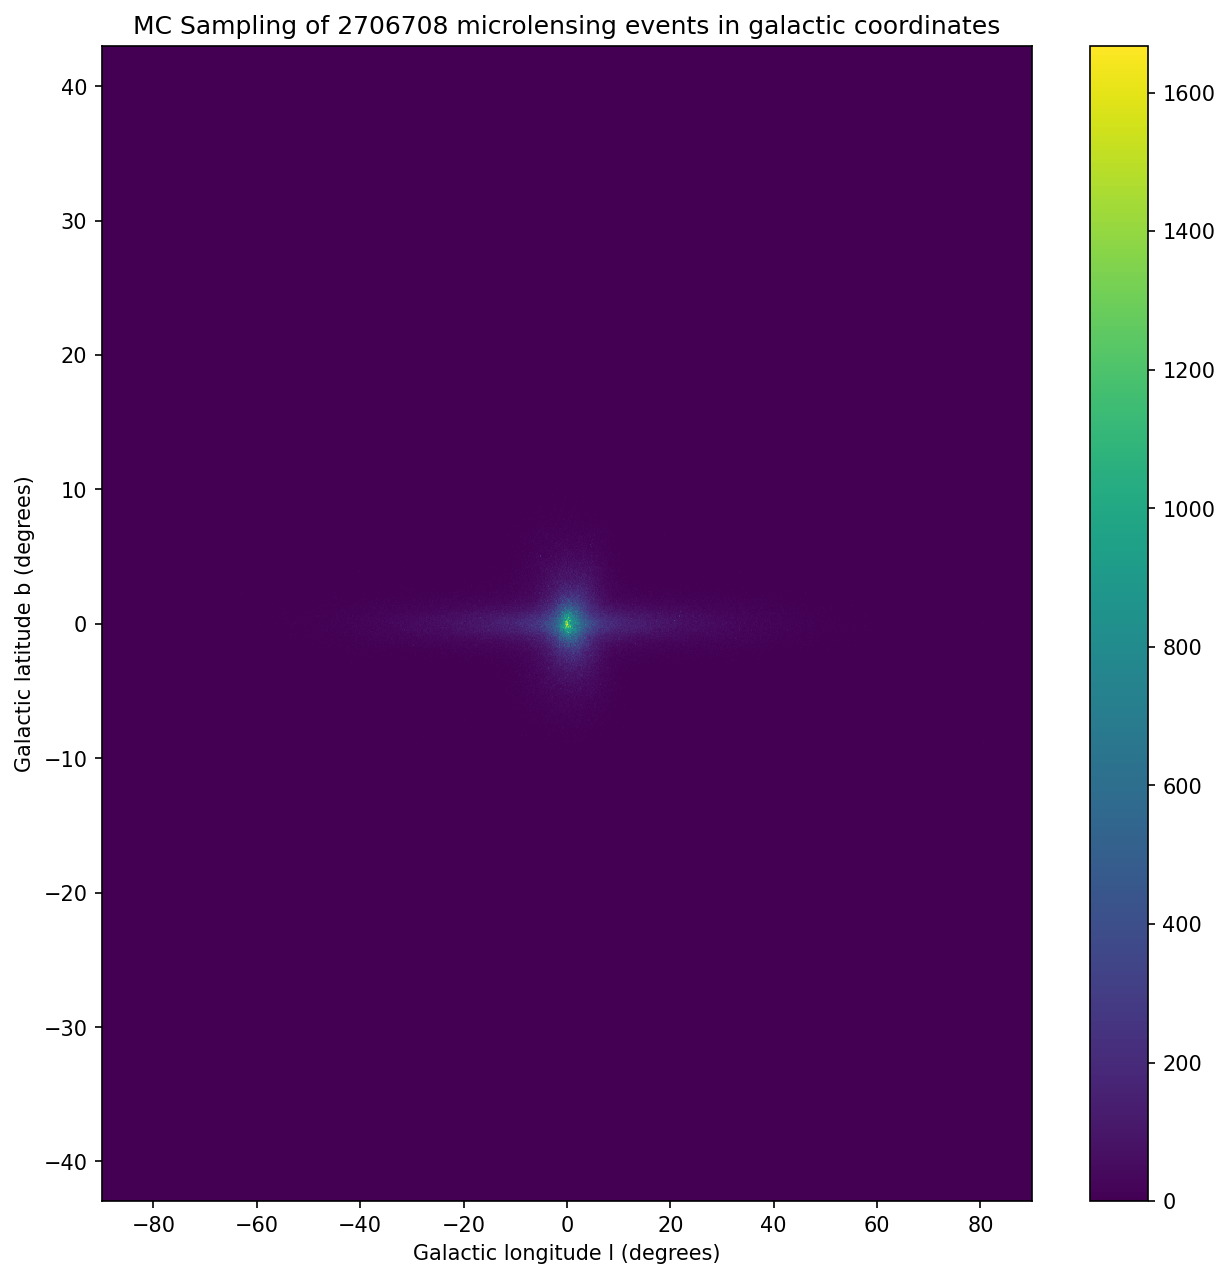

In [242]:
plt.subplots(figsize=(10,10))

hist, xedges, yedges, im = plt.hist2d(*samples[:,:2].T, bins=1000);
plt.colorbar()
plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')


In [20]:
# binned_rates={} #np.zeros_like(hist)
# for i in tqdm.tqdm(range(len(xedges)-1)):
#     xmask = (samples[:,0] >= xedges[i]) & (samples[:,0] < xedges[i+1])
#     for j in range(len(yedges)-1):
#         ymask = (samples[:,1] >= yedges[j]) & (samples[:,1] < yedges[j+1])
#         sample_coords = samples[xmask & ymask]
#         sample_vals = [sample_density(sample_coord, pbh) for sample_coord in sample_coords]
#         binned_rates[(i,j)] = sample_vals
        

In [21]:
from bisect import bisect_left

In [22]:
# binned_rates={} #np.zeros_like(hist)
# for nsample, sample in tqdm.tqdm(enumerate(samples)):
#     i = bisect_left(xedges, sample[0])
#     j = bisect_left(yedges, sample[1])
#     if (i,j) in binned_rates:
#         binned_rates[(i,j)].append(sample_density(sample, pbh))
#     else:
#         binned_rates[(i,j)] = [sample_density(sample, pbh)]


In [23]:
# binned_rates[(len(xedges)//2, len(yedges)//2)]

In [41]:
# binned_rates_mean=np.zeros_like(hist)
# for ix, iy in tqdm.tqdm(np.ndindex(binned_rates_mean.shape)):
#     if (ix,iy) in binned_rates:
#         binned_rates_mean[(ix, iy)] = np.mean(binned_rates[(ix,iy)])

250000it [00:00, 1071380.33it/s]


In [53]:
# binned_rates_std=np.zeros_like(hist)
# for ix, iy in tqdm.tqdm(np.ndindex(binned_rates_mean.shape)):
#     if (ix,iy) in binned_rates:
#         binned_rates_std[(ix, iy)] = np.std(binned_rates[(ix,iy)])

250000it [00:00, 573678.57it/s]


In [67]:
# binned_rates_mean.mean()*8*(10*24*365)**2

3586071.281790632

In [24]:
# plt.hist(binned_rates_mean.flat)

In [26]:
# plt.imshow(binned_rates_mean)
# plt.colorbar()

In [27]:
# slicesize = 80
# bulge_slice = (slice(len(xedges)//2-slicesize,len(xedges)//2+slicesize), slice(len(yedges)//2-slicesize,len(yedges)//2+slicesize))
# #bulge_slice = np.ogrid[len(xedges)//2-slicesize:len(xedges)//2+slicesize, len(yedges)//2-slicesize:len(yedges)//2+slicesize]
# plt.imshow(binned_rates_std[bulge_slice]/binned_rates_mean[bulge_slice])
# plt.colorbar()

In [28]:
(2*(-10,10))

(-10, 10, -10, 10)

Text(0, 0.5, 'Galactic latitude b (degrees)')

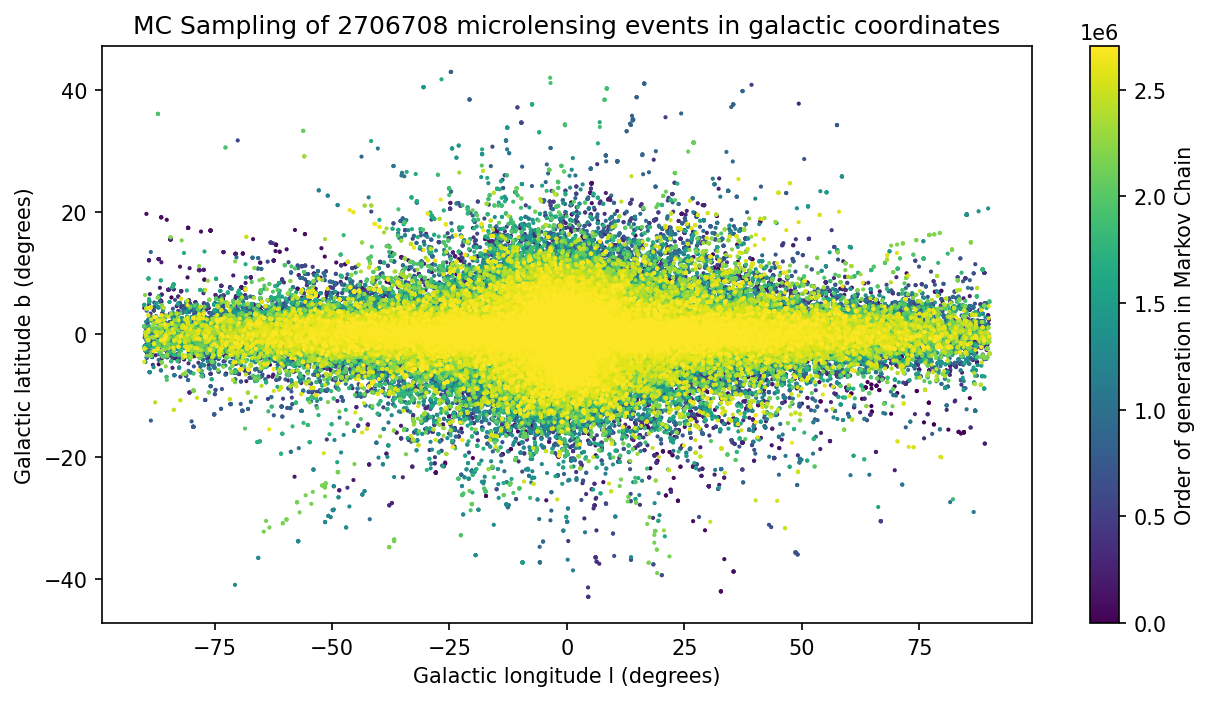

In [243]:

x,y = samples[:,:2].T
plt.scatter(x,y, c=np.arange(len(x)),s=1)
cbar = plt.colorbar()
cbar.set_label('Order of generation in Markov Chain')
plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

Text(0, 0.5, 'Galactic latitude b (degrees)')

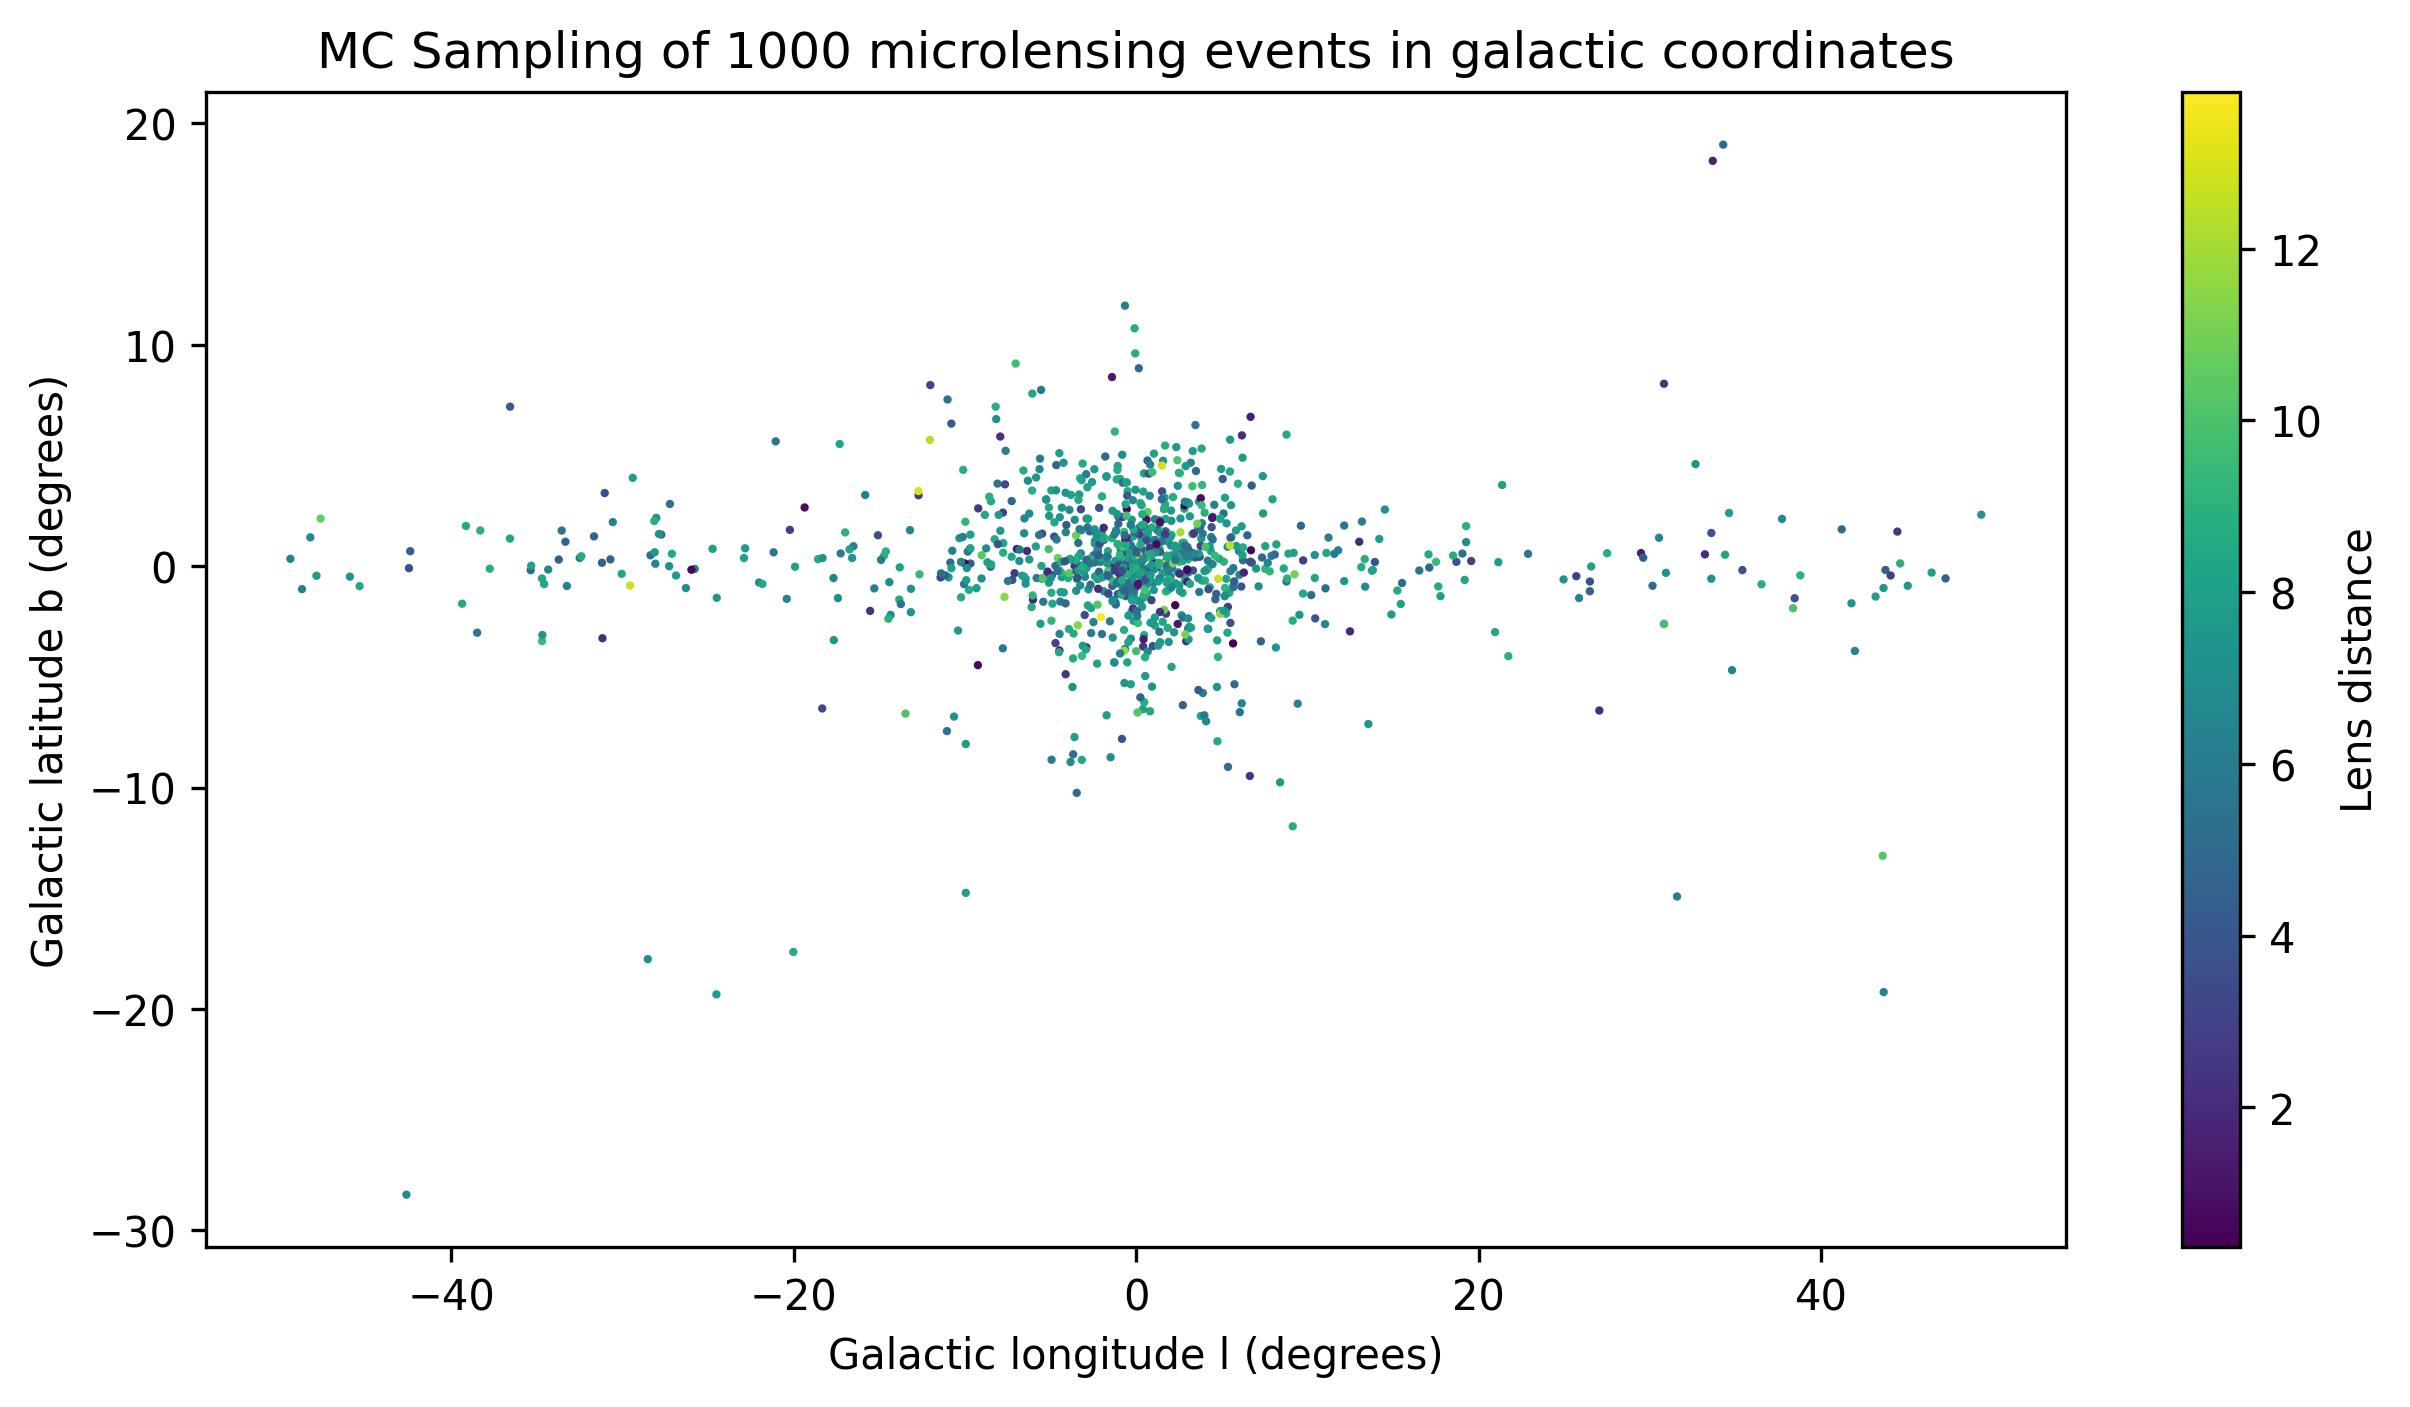

In [430]:

x,y,dists = samples[np.random.choice(np.arange(len(samples)), 1000)][:,:3].T
distsort = np.argsort(dists)
plt.scatter(x[distsort],y[distsort], c=dists,s=1)
cbar = plt.colorbar()
cbar.set_label('Lens distance')
plt.title(f'MC Sampling of {len(x)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

In [426]:
dists

array([2.52294675, 7.30406656, 9.60805921, ..., 7.36985403, 6.2224447 ,
       7.39579028])

Text(0, 0.5, 'Galactic latitude b (degrees)')

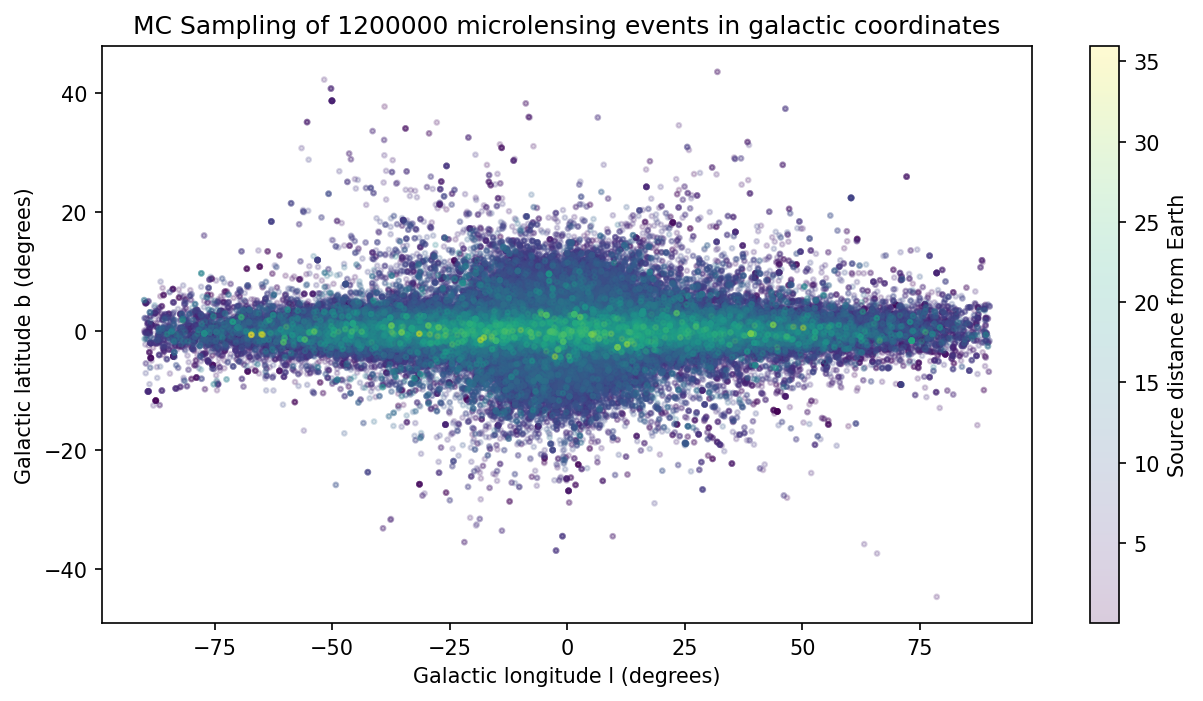

In [28]:
#density = gaussian_kde(samples[:,:2])(samples[:,:2])
dists = samples[:,2]
distsort = dists.argsort()
x,y = samples[:,:2].T
#x=x[dsort]
#y=y[dsort]
plt.scatter(x[distsort],y[distsort], c=dists[distsort],s=5, alpha=.2)
cbar = plt.colorbar()
cbar.set_label("Source distance from Earth")

plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

(array([ 5.,  3.,  4.,  5.,  1.,  0.,  3.,  3.,  4.,  4.,  5.,  4.,  3.,
         4.,  6., 10.,  4.,  5.,  6.,  7.,  4.,  4.,  9., 10.,  7.,  7.,
        11.,  7., 11.,  8.,  8., 15., 12., 16., 26., 12.,  9., 12., 17.,
        13., 20., 12., 19., 22., 15., 18., 13., 15., 17., 19., 22., 21.,
        33., 31., 44., 23., 33., 32., 32., 38., 45., 44., 22., 22., 12.,
         8.,  8.,  5.,  5.,  3.,  4.,  6.,  4.,  4.,  2.,  1.,  0.,  1.,
         4.,  2.,  0.,  0.,  3.,  0.,  2.,  0.,  0.,  1.,  1.,  1.,  1.,
         1.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  1.]),
 array([ 0.37066847,  0.50519163,  0.63971479,  0.77423795,  0.90876111,
         1.04328428,  1.17780744,  1.3123306 ,  1.44685376,  1.58137693,
         1.71590009,  1.85042325,  1.98494641,  2.11946957,  2.25399274,
         2.3885159 ,  2.52303906,  2.65756222,  2.79208538,  2.92660855,
         3.06113171,  3.19565487,  3.33017803,  3.46470119,  3.59922436,
         3.73374752,  3.86827068,  4.00279384,  4.13731701,  4.271840

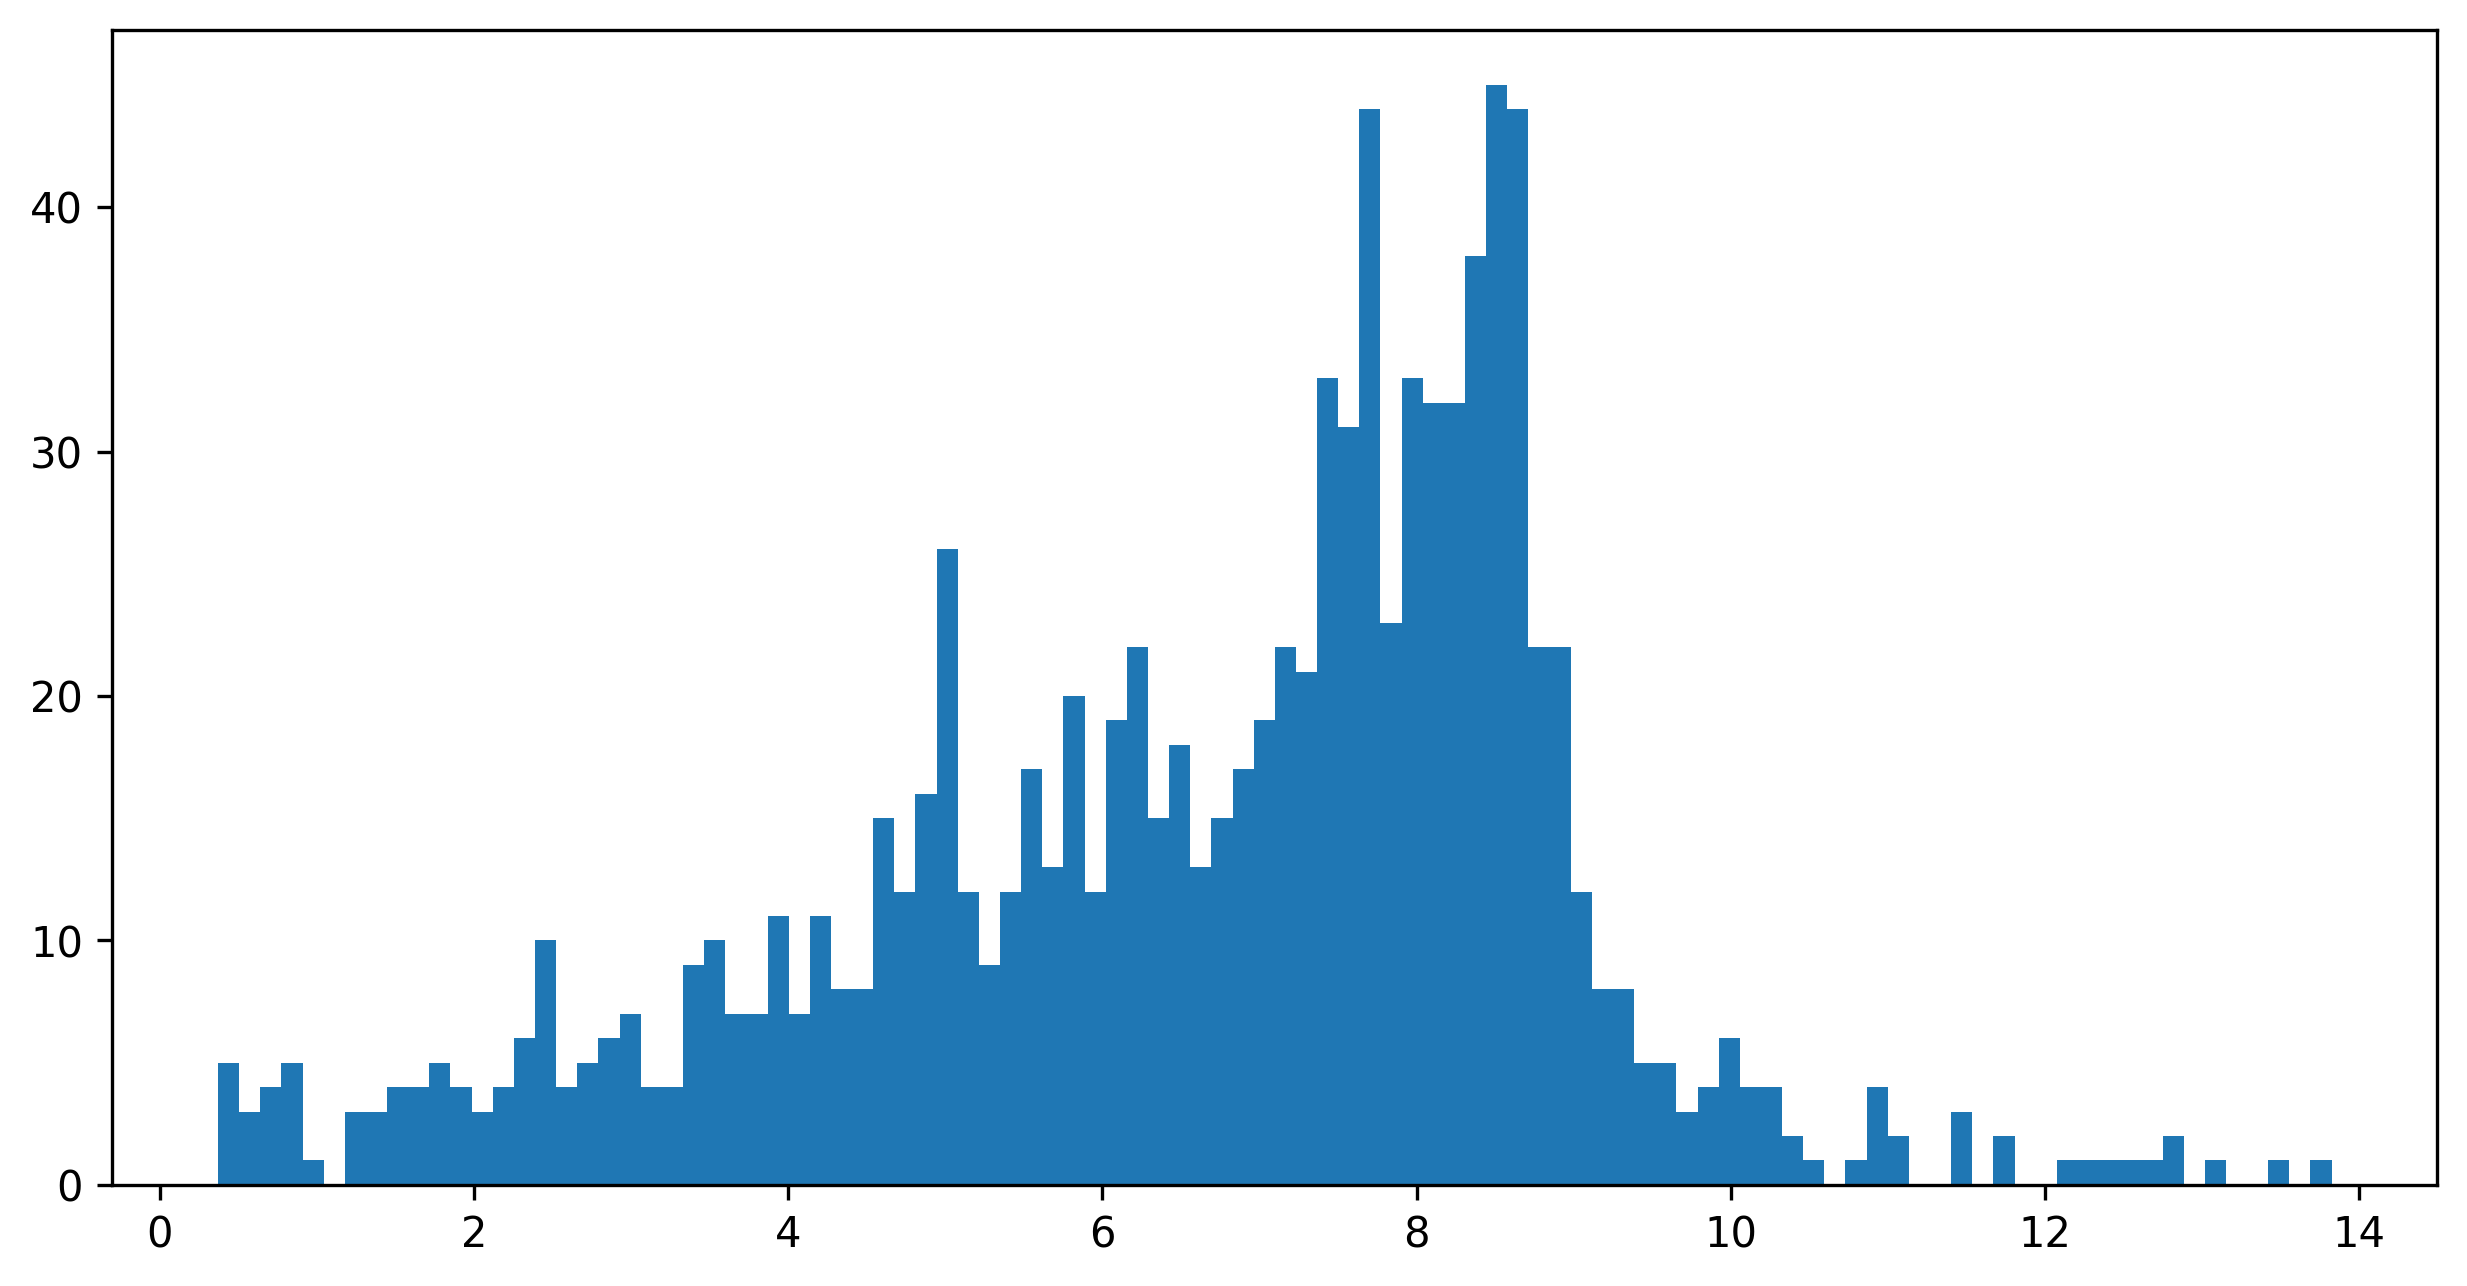

In [641]:
plt.hist(dists, bins=100)

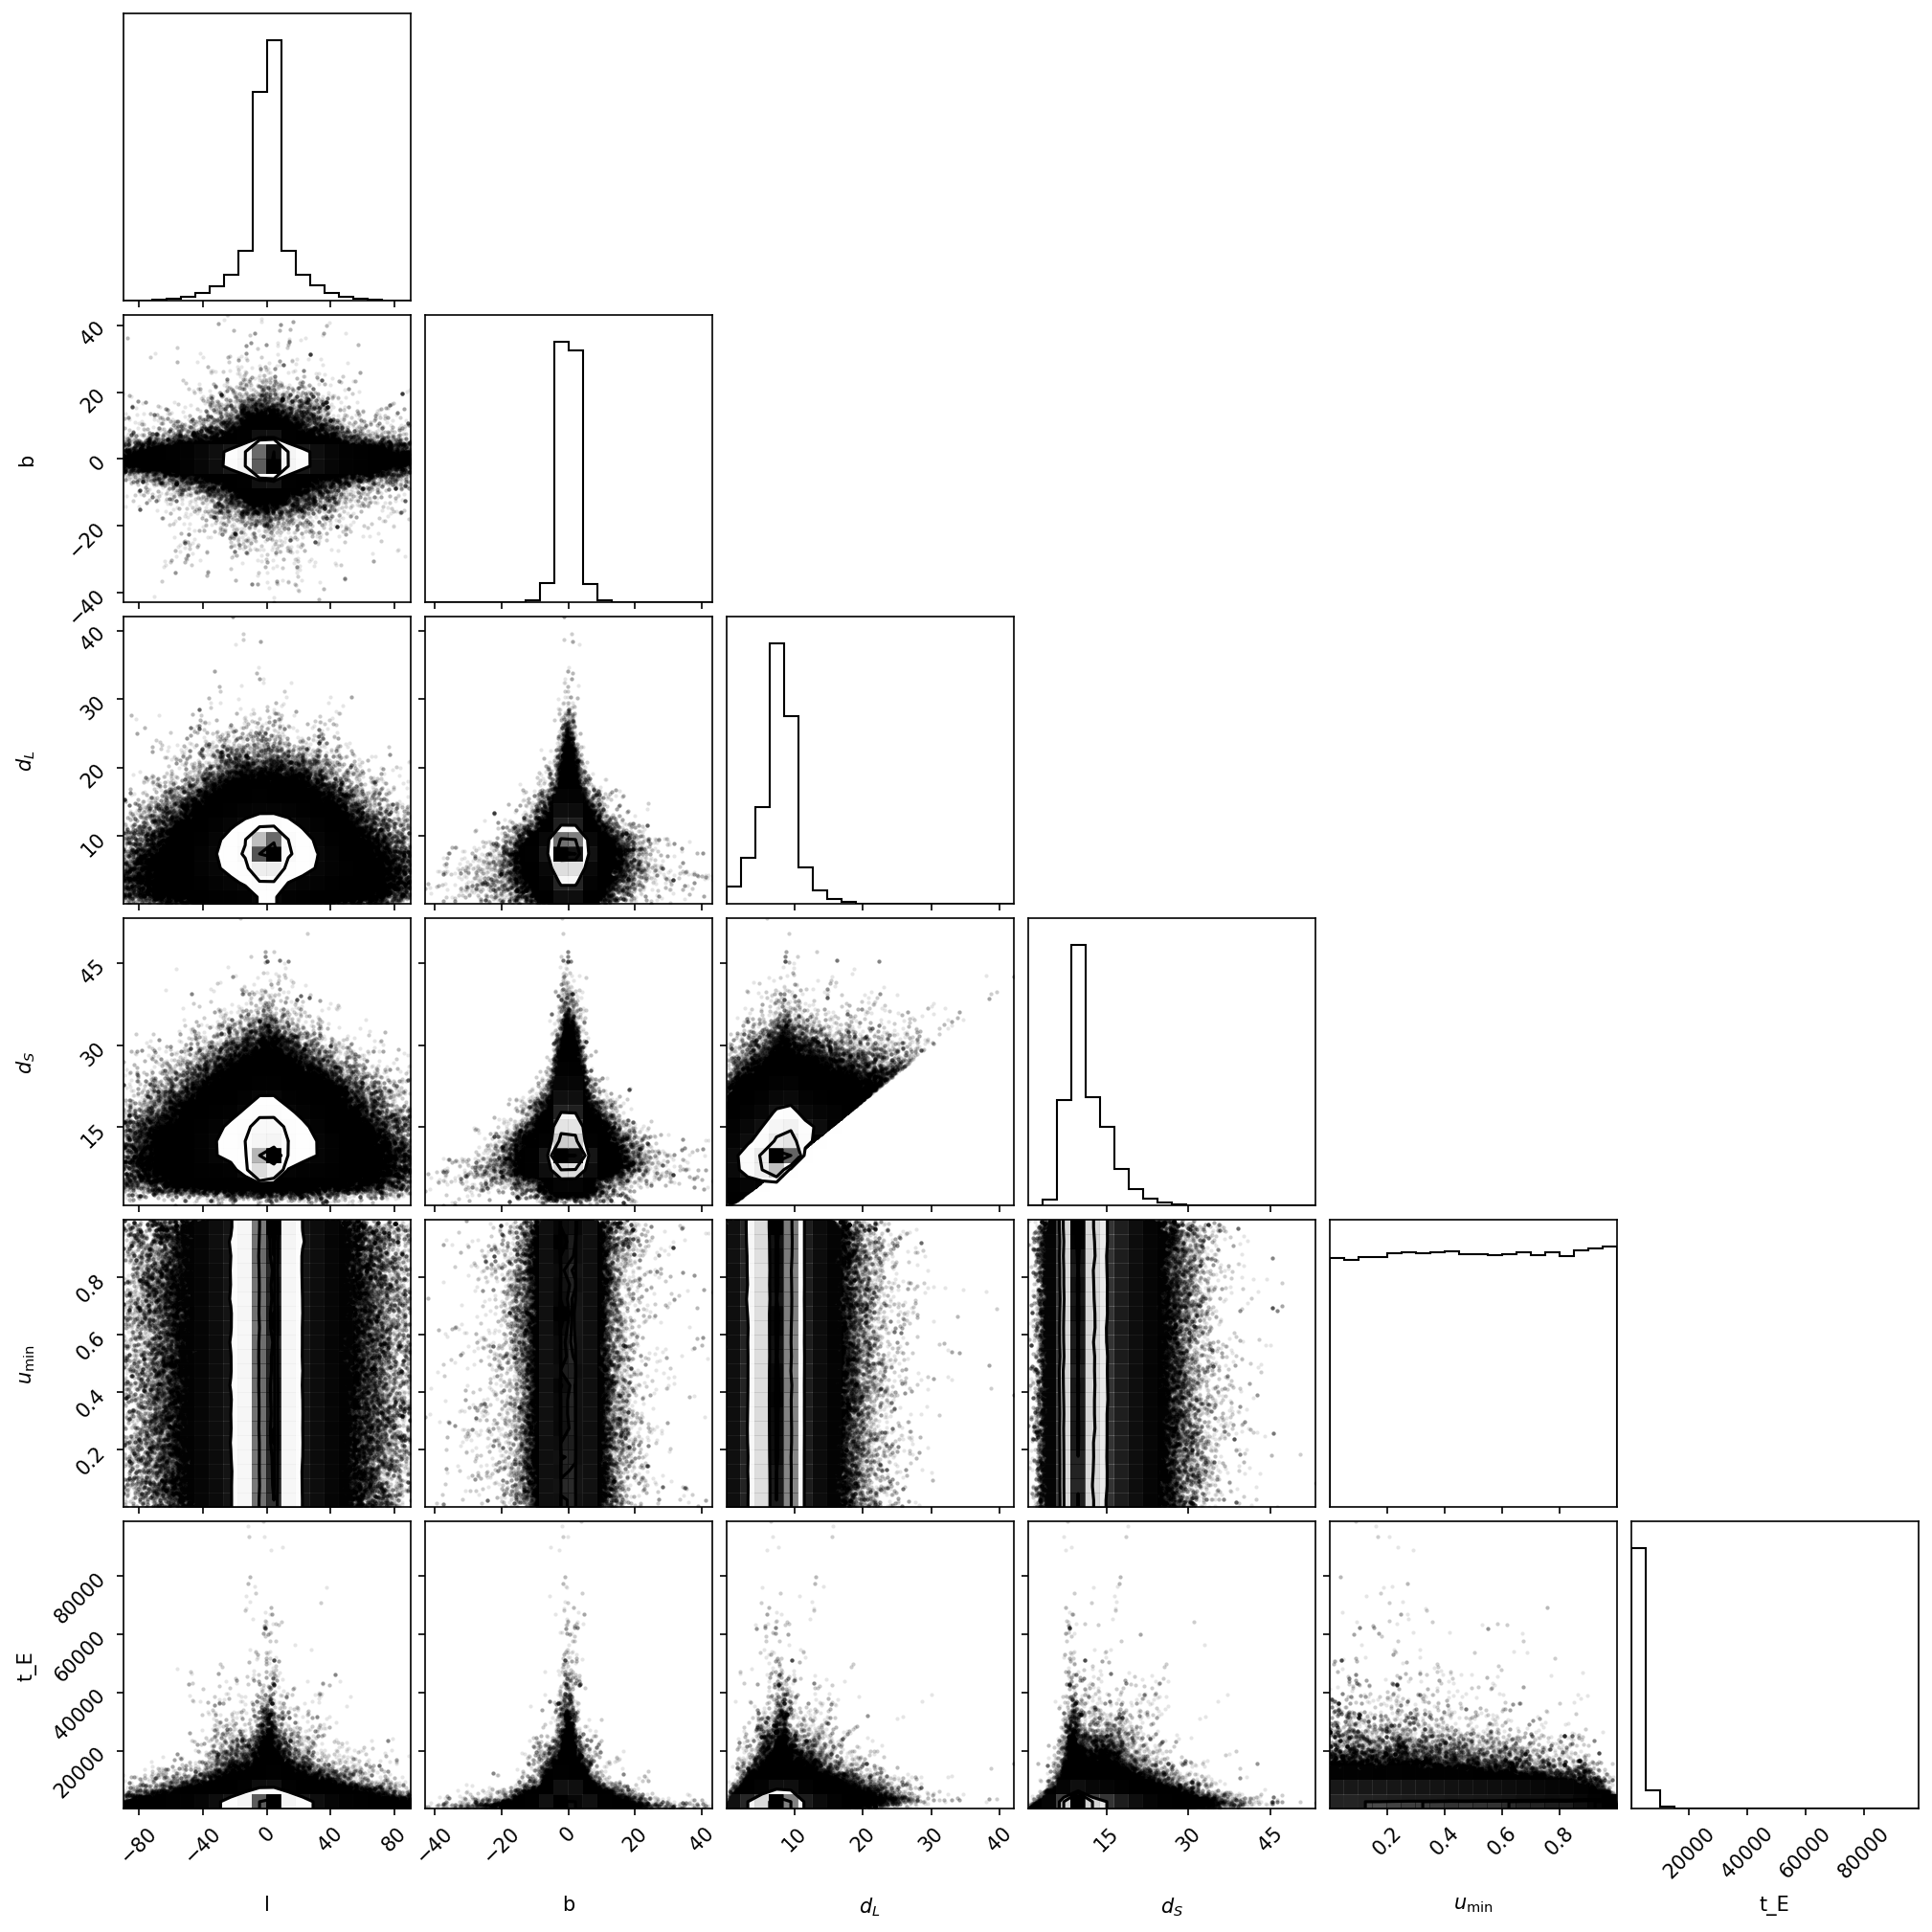

In [244]:
fig = corner.corner(
    samples, labels=['l','b',r'$d_L$',r'$d_S$',r'$u_\min$',r't_E'])

(array([12718., 11506., 11830., 11465., 12345., 12118., 12258., 11879.,
        12162., 12005., 11761., 11331., 11888., 12081., 11867., 12118.,
        11322., 12028., 12171., 11952., 12190., 11959., 11583., 11794.,
        11467., 11765., 12271., 11672., 11708., 11658., 11924., 11952.,
        12292., 11761., 11791., 12204., 12104., 11922., 11993., 11715.,
        12361., 11955., 12202., 12213., 12173., 12059., 12114., 11967.,
        12013., 11842., 11879., 11705., 12158., 12044., 12162., 12044.,
        11849., 12309., 11918., 12129., 11979., 11792., 12158., 12106.,
        12051., 11966., 12242., 12016., 12489., 12073., 12348., 12143.,
        12039., 12176., 11695., 12510., 11936., 12031., 12257., 11749.,
        12368., 11938., 12308., 12104., 11979., 12007., 12256., 12598.,
        12065., 11724., 12158., 11822., 12152., 12524., 12266., 11775.,
        11646., 11729., 11871., 11328.]),
 array([6.94006618e-07, 1.00002741e-02, 1.99998542e-02, 2.99994343e-02,
        3.99990144e-02

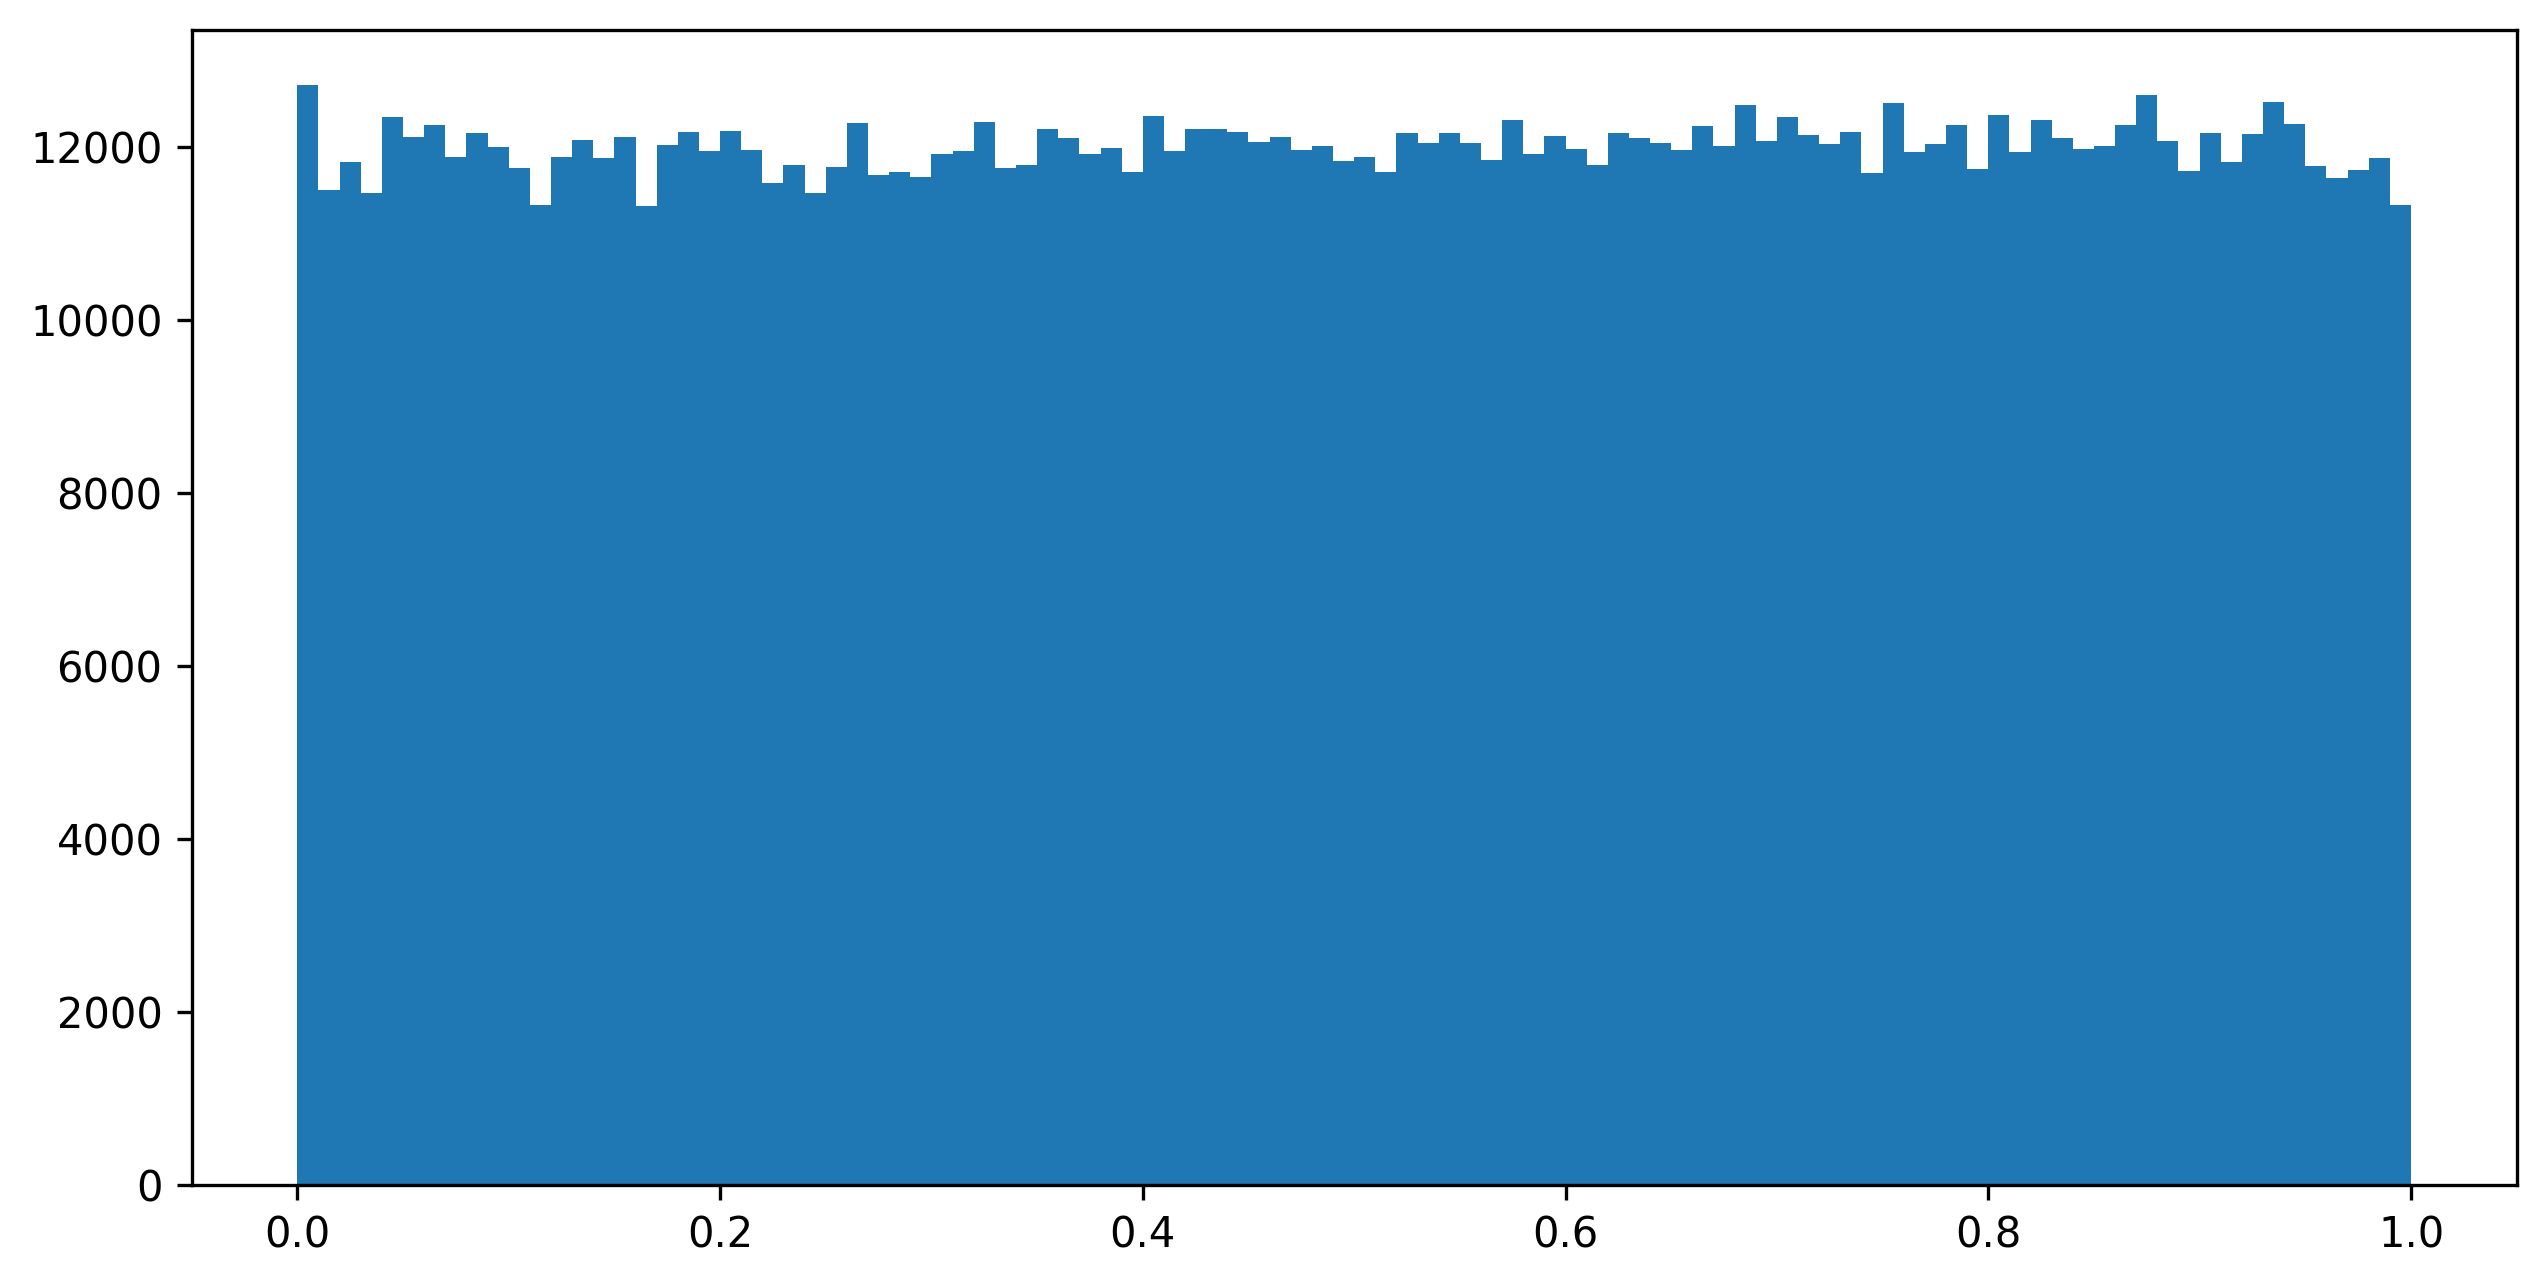

In [643]:
plt.hist(samples[:,4],bins=100)

In [395]:
# estimate rate

sample_rates = np.array([np.exp(sample_density_log(sample, pbh)) for sample in samples])

In [396]:
total_rate = np.sum(sample_rates**2)/np.sum(sample_rates)

In [397]:
total_rate

0.0037518247761582093

In [393]:
np.sum(sample_rates)

-inf

In [389]:
sample_rates*sample_rates

array([341.18762149,  75.0097404 , 194.87239411, ..., 273.04770943,
       114.15238471,          inf])

In [651]:
np.percentile(samples,(45,55),axis=0).T

array([[-1.59734585e-01,  1.10482593e+00],
       [-1.67477138e-01,  1.65651204e-01],
       [ 7.66230497e+00,  8.09550553e+00],
       [ 9.69931105e+00,  1.05357468e+01],
       [ 4.52122384e-01,  5.52150246e-01],
       [ 1.91662025e+03,  2.20918476e+03]])

In [145]:
ranges=np.asarray(list(zip(np.min(samples,axis=0),np.max(samples,axis=0))))
# ranges=np.asarray(np.percentile(samples,(49,51),axis=0).T)
# ranges[]

In [71]:
ranges[:2] = np.asarray(np.percentile(samples[:,:2],(49,51),axis=0).T)

In [48]:
#result,abserr = scipy.integrate.nquad(lambda *x:  sample_density(x,pbh), ranges)

In [ ]:
result,abserr

(-inf, inf)

In [72]:
ranges

array([[ 3.87387880e-01,  6.29535358e-01],
       [-2.92731899e-02,  3.71576936e-02],
       [ 7.05725987e-03,  3.77662941e+01],
       [ 6.08825777e-01,  4.65859733e+01],
       [ 1.68072281e-06,  9.99973867e-01],
       [ 4.07806822e+01,  8.41988675e+04]])

In [90]:
# n_integral_samples = 1000000
# integral_samples = []
# uniform_sample_coords = (np.random.random_sample(n_integral_samples*6).reshape(n_integral_samples,6))*(ranges[:,1]-ranges[:,0])+ranges[:,0]
# for point in uniform_sample_coords:
#     integral_samples.append(sample_density(point, pbh))


In [74]:
range_volume = np.product(ranges[:,1]-ranges[:,0])

In [76]:
np.mean(integral_samples)*range_volume*(10*24*365)

1428409.285079904

In [457]:
# for point in uniform_sample_coords:
#     for i,c in enumerate(point):
#         if (c < ranges[i,0] or c > ranges[i,1]):
#             print('oops')
    

(1, 2, 3, 1, 1, 1)

In [193]:
edges = np.linspace(np.min(samples, axis=0), np.max(samples, axis=0), 20)

In [194]:
binned_samples={} 
for nsample, sample in tqdm.tqdm(enumerate(samples)):
    indices = tuple(bisect_left(edges[:,icoord], sample[icoord]) for icoord in range(len(sample)))
    if indices in binned_samples:
        binned_samples[indices].append(sample)
    else:
        binned_samples[indices] = [sample]

600000it [00:01, 382907.47it/s]


In [195]:
# binned_counts=np.zeros(shape=[edges.shape[0]]*edges.shape[1])
# for indices, sample_list in binned_samples.items():
#     binned_counts[indices] = len(sample_list)

In [245]:
binned_counts_dict={}
for indices, sample_list in binned_samples.items():
    binned_counts_dict[indices] = len(sample_list)

In [246]:
def coord_to_bin_indices(edges, coords):
    return tuple(bisect_left(edges[:,icoord], coords[icoord]) for icoord in range(len(coords)))

In [247]:
binned_rates={} 
for nsample, sample in tqdm.tqdm(enumerate(samples)):
    indices = tuple(bisect_left(edges[:,icoord], sample[icoord]) for icoord in range(len(sample)))
    if indices in binned_rates:
        binned_rates[indices].append(sample_density(sample, pbh))
    else:
        binned_rates[indices] = [sample_density(sample, pbh)]

452302it [00:08, 51409.40it/s]


KeyboardInterrupt: 

In [ ]:
binned_rates_mean_dict={idx:np.mean(rates) for idx,rates in binned_rates.items()}

In [ ]:
# binned_rates_ratios = {ind:binned_rates_mean_dict[ind]/binned_counts_dict[ind] for ind in binned_rates}

In [ ]:
# binned_rates_mean=np.zeros(shape=[edges.shape[0]]*edges.shape[1])
# for indices in tqdm.tqdm(np.ndindex(binned_rates_mean.shape)):
#     if indices in binned_rates:
#         binned_rates_mean[indices] = np.mean(binned_rates[indices])

In [ ]:
biggest_bin=max(binned_counts_dict, key=binned_counts_dict.get)

In [ ]:
len(binned_samples[biggest_bin])

3640

In [ ]:
len(binned_samples)/20**6

0.00073225

In [248]:
def box_from_indices(edges, indices):
    return np.array([[edges[idx-1][i],edges[idx][i]] for i, idx in enumerate(indices)])

In [249]:
edges[-2:].T

array([[8.05068721e+01, 8.99766958e+01],
       [3.03738616e+01, 3.45033412e+01],
       [2.85573536e+01, 3.01434306e+01],
       [4.44046635e+01, 4.68139616e+01],
       [9.47354880e-01, 9.99985052e-01],
       [6.91663275e+04, 7.30070416e+04]])

In [250]:
box_from_indices(edges,biggest_bin)

array([[-4.72154066e+00,  4.74828298e+00],
       [-2.66197457e+00,  1.46750496e+00],
       [ 7.93835237e+00,  9.52442939e+00],
       [ 8.26519221e+00,  1.06744903e+01],
       [ 8.42094537e-01,  8.94724709e-01],
       [ 3.34744117e+01,  3.87418847e+03]])

In [251]:
# scipy.integrate.nquad(lambda *params: sample_density(params, pbh), box_from_indices(edges,biggest_bin))

In [252]:
def region_volume(region):
    return np.product(region[:,1]-region[:,0])
def mc_integrate(f, region, nsamples=10000):
    sample_points = np.random.random(size=(nsamples, len(region)))
    sample_points = (region[:,1]-region[:,0])*sample_points+region[:,0]
    samples_values = [f(*_) for _ in sample_points]
    return np.mean(samples_values)*region_volume(region)


In [253]:
%time
mc_integrate(lambda *params: sample_density(params, pbh), box_from_indices(edges,biggest_bin))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.39 µs


0.07031085681028103

In [262]:
binned_rates_integral={} 
for indices in binned_samples:
    try:
        binned_rates_integral[indices] = mc_integrate(lambda *params: sample_density(params, pbh), box_from_indices(edges,indices),nsamples=300)
    except:
        print(indices)

In [263]:
binned_rates_ratios = {ind:binned_rates_integral[ind]/binned_counts_dict[ind] for ind in binned_rates_integral}

In [264]:
ratio_array=np.array(list(binned_rates_ratios.values()))

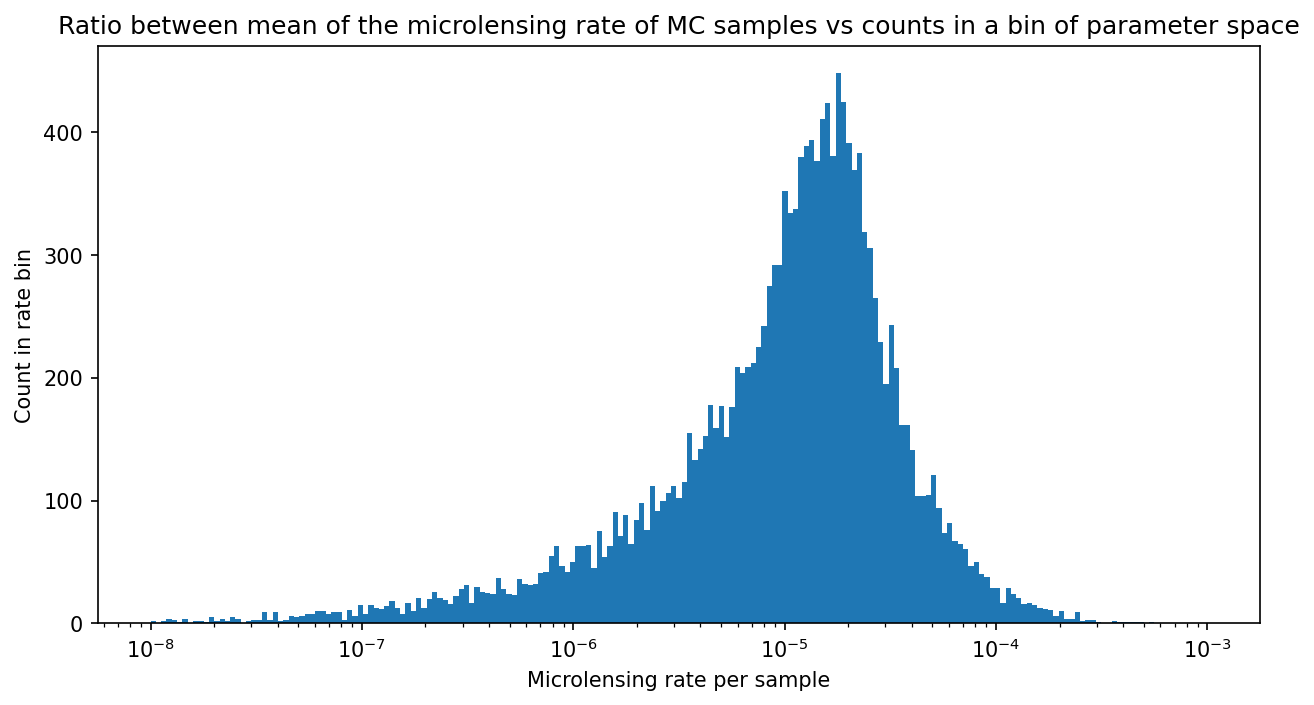

In [265]:
bins=np.logspace(-8,-3,200)
# bins = np.linspace(10**(-7), .1,200)
plt.hist(ratio_array,bins=bins)
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
plt.xscale('log')
#plt.yscale('log')

In [220]:
np.sum([ratio_array==0])/len(binned_rates_ratios)

0.5695098835634985

In [217]:
len(binned_rates_ratios)

36930

Text(0, 0.5, 'Count in rate bin')

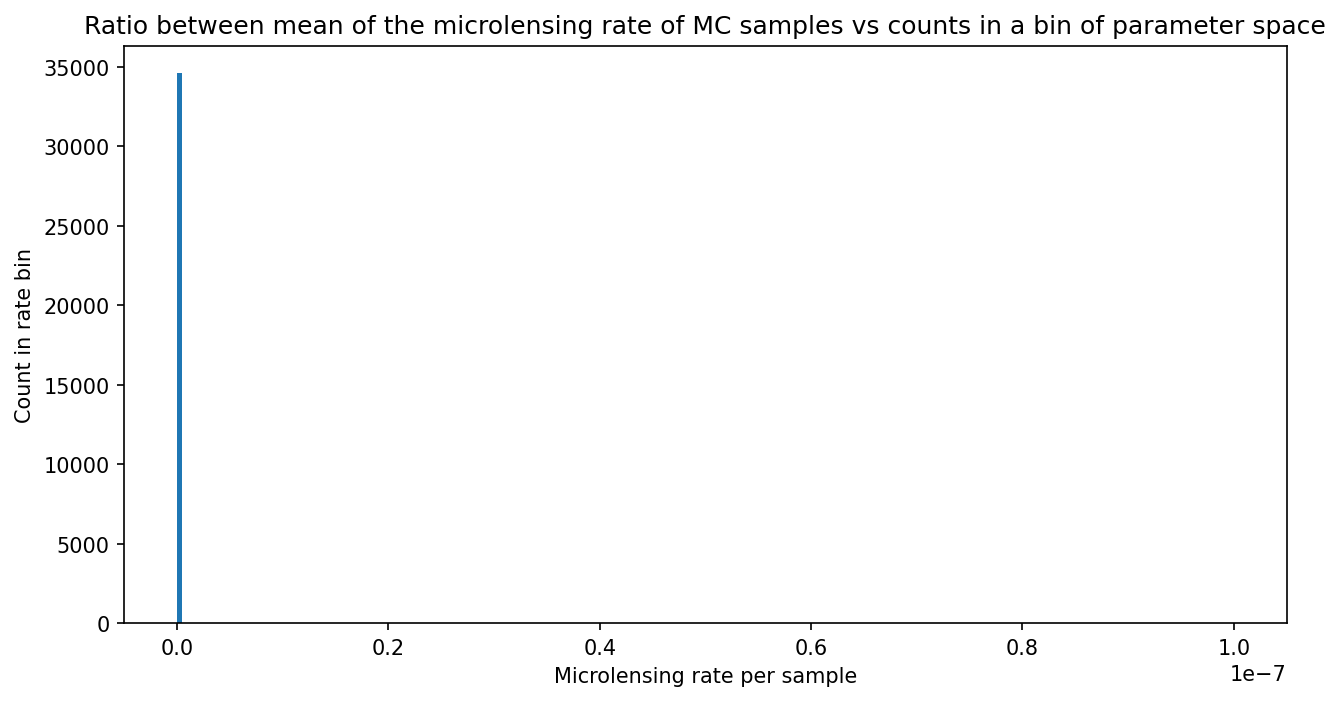

In [129]:
# bins=np.logspace(-8,-3,200)
bins = np.linspace(0, 10**(-7),200)
plt.hist(ratio_array,bins=bins)
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
# plt.xscale('log')
#plt.yscale('log')

In [130]:
ratio_array

array([6.27038889e-06, 4.80965839e-06, 3.95063787e-06, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [71]:
binned_rates_ratios_bulge={}
bulge_bins = coord_to_bin_indices(edges[:,:2], [0,0])
for idx, ratio in binned_rates_ratios.items():
    if idx[:2]==bulge_bins:
        binned_rates_ratios_bulge[idx] = ratio

In [72]:
bulge_bins

(10, 10)

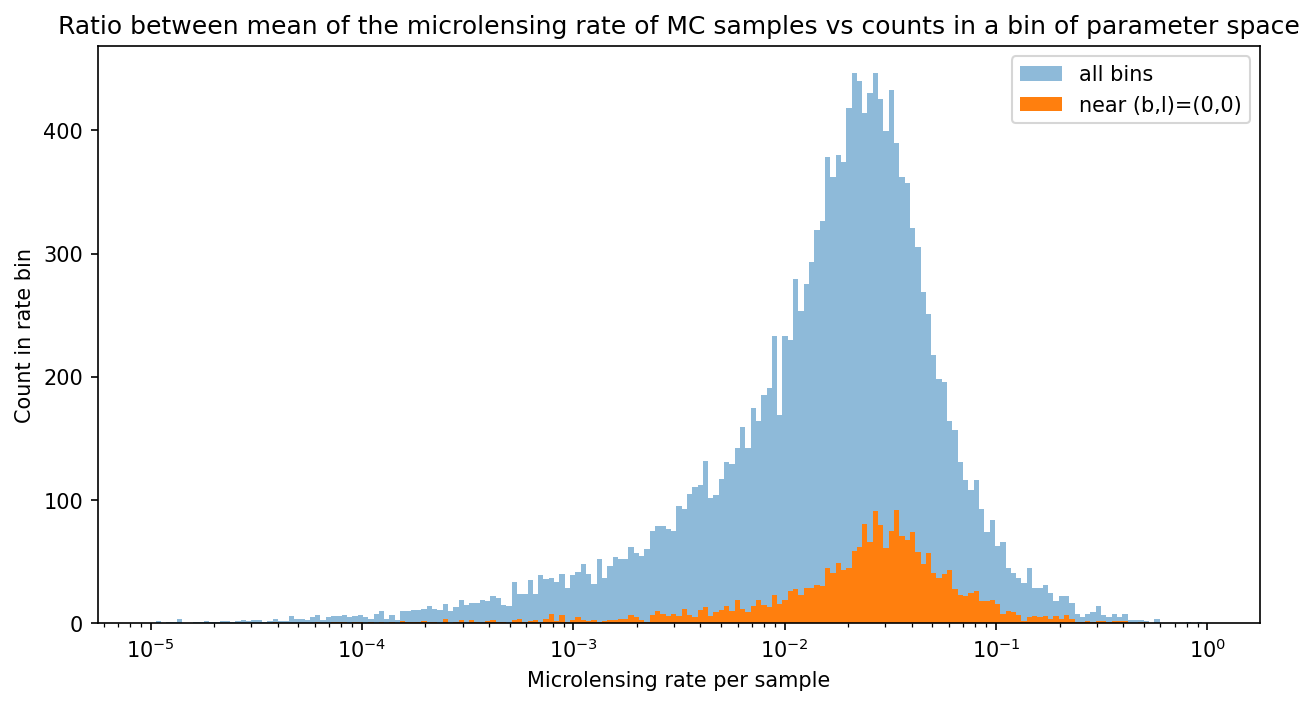

In [76]:
ratio_array_bulge=np.array(list(binned_rates_ratios_bulge.values()))

plt.hist(ratio_array,bins=np.logspace(-5,0,200),label='all bins',alpha=.5)
plt.hist(ratio_array_bulge,bins=np.logspace(-5,0,200),label='near (b,l)=(0,0)')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.legend()
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
plt.xscale('log')
#plt.yscale('log')

# who's in the tails?

In [221]:
binned_rates_ratios_low_tail={}
bulge_bins = coord_to_bin_indices(edges[:,:2], [0,0])
for idx, ratio in binned_rates_ratios.items():
    if ratio/4<10**-7 and ratio :
        binned_rates_ratios_low_tail[idx] = ratio

In [225]:
low_tail_bins = np.array(list(binned_rates_ratios_low_tail.keys()))

In [228]:
print(low_tail_bins.mean(axis=0))
print(low_tail_bins.std(axis=0))


[ 9.97574112 11.1469803   5.34339901  5.75515559  9.54644633  1.42929479]
[3.8961277  1.02907672 2.62165117 2.31792977 5.17243686 0.96891468]


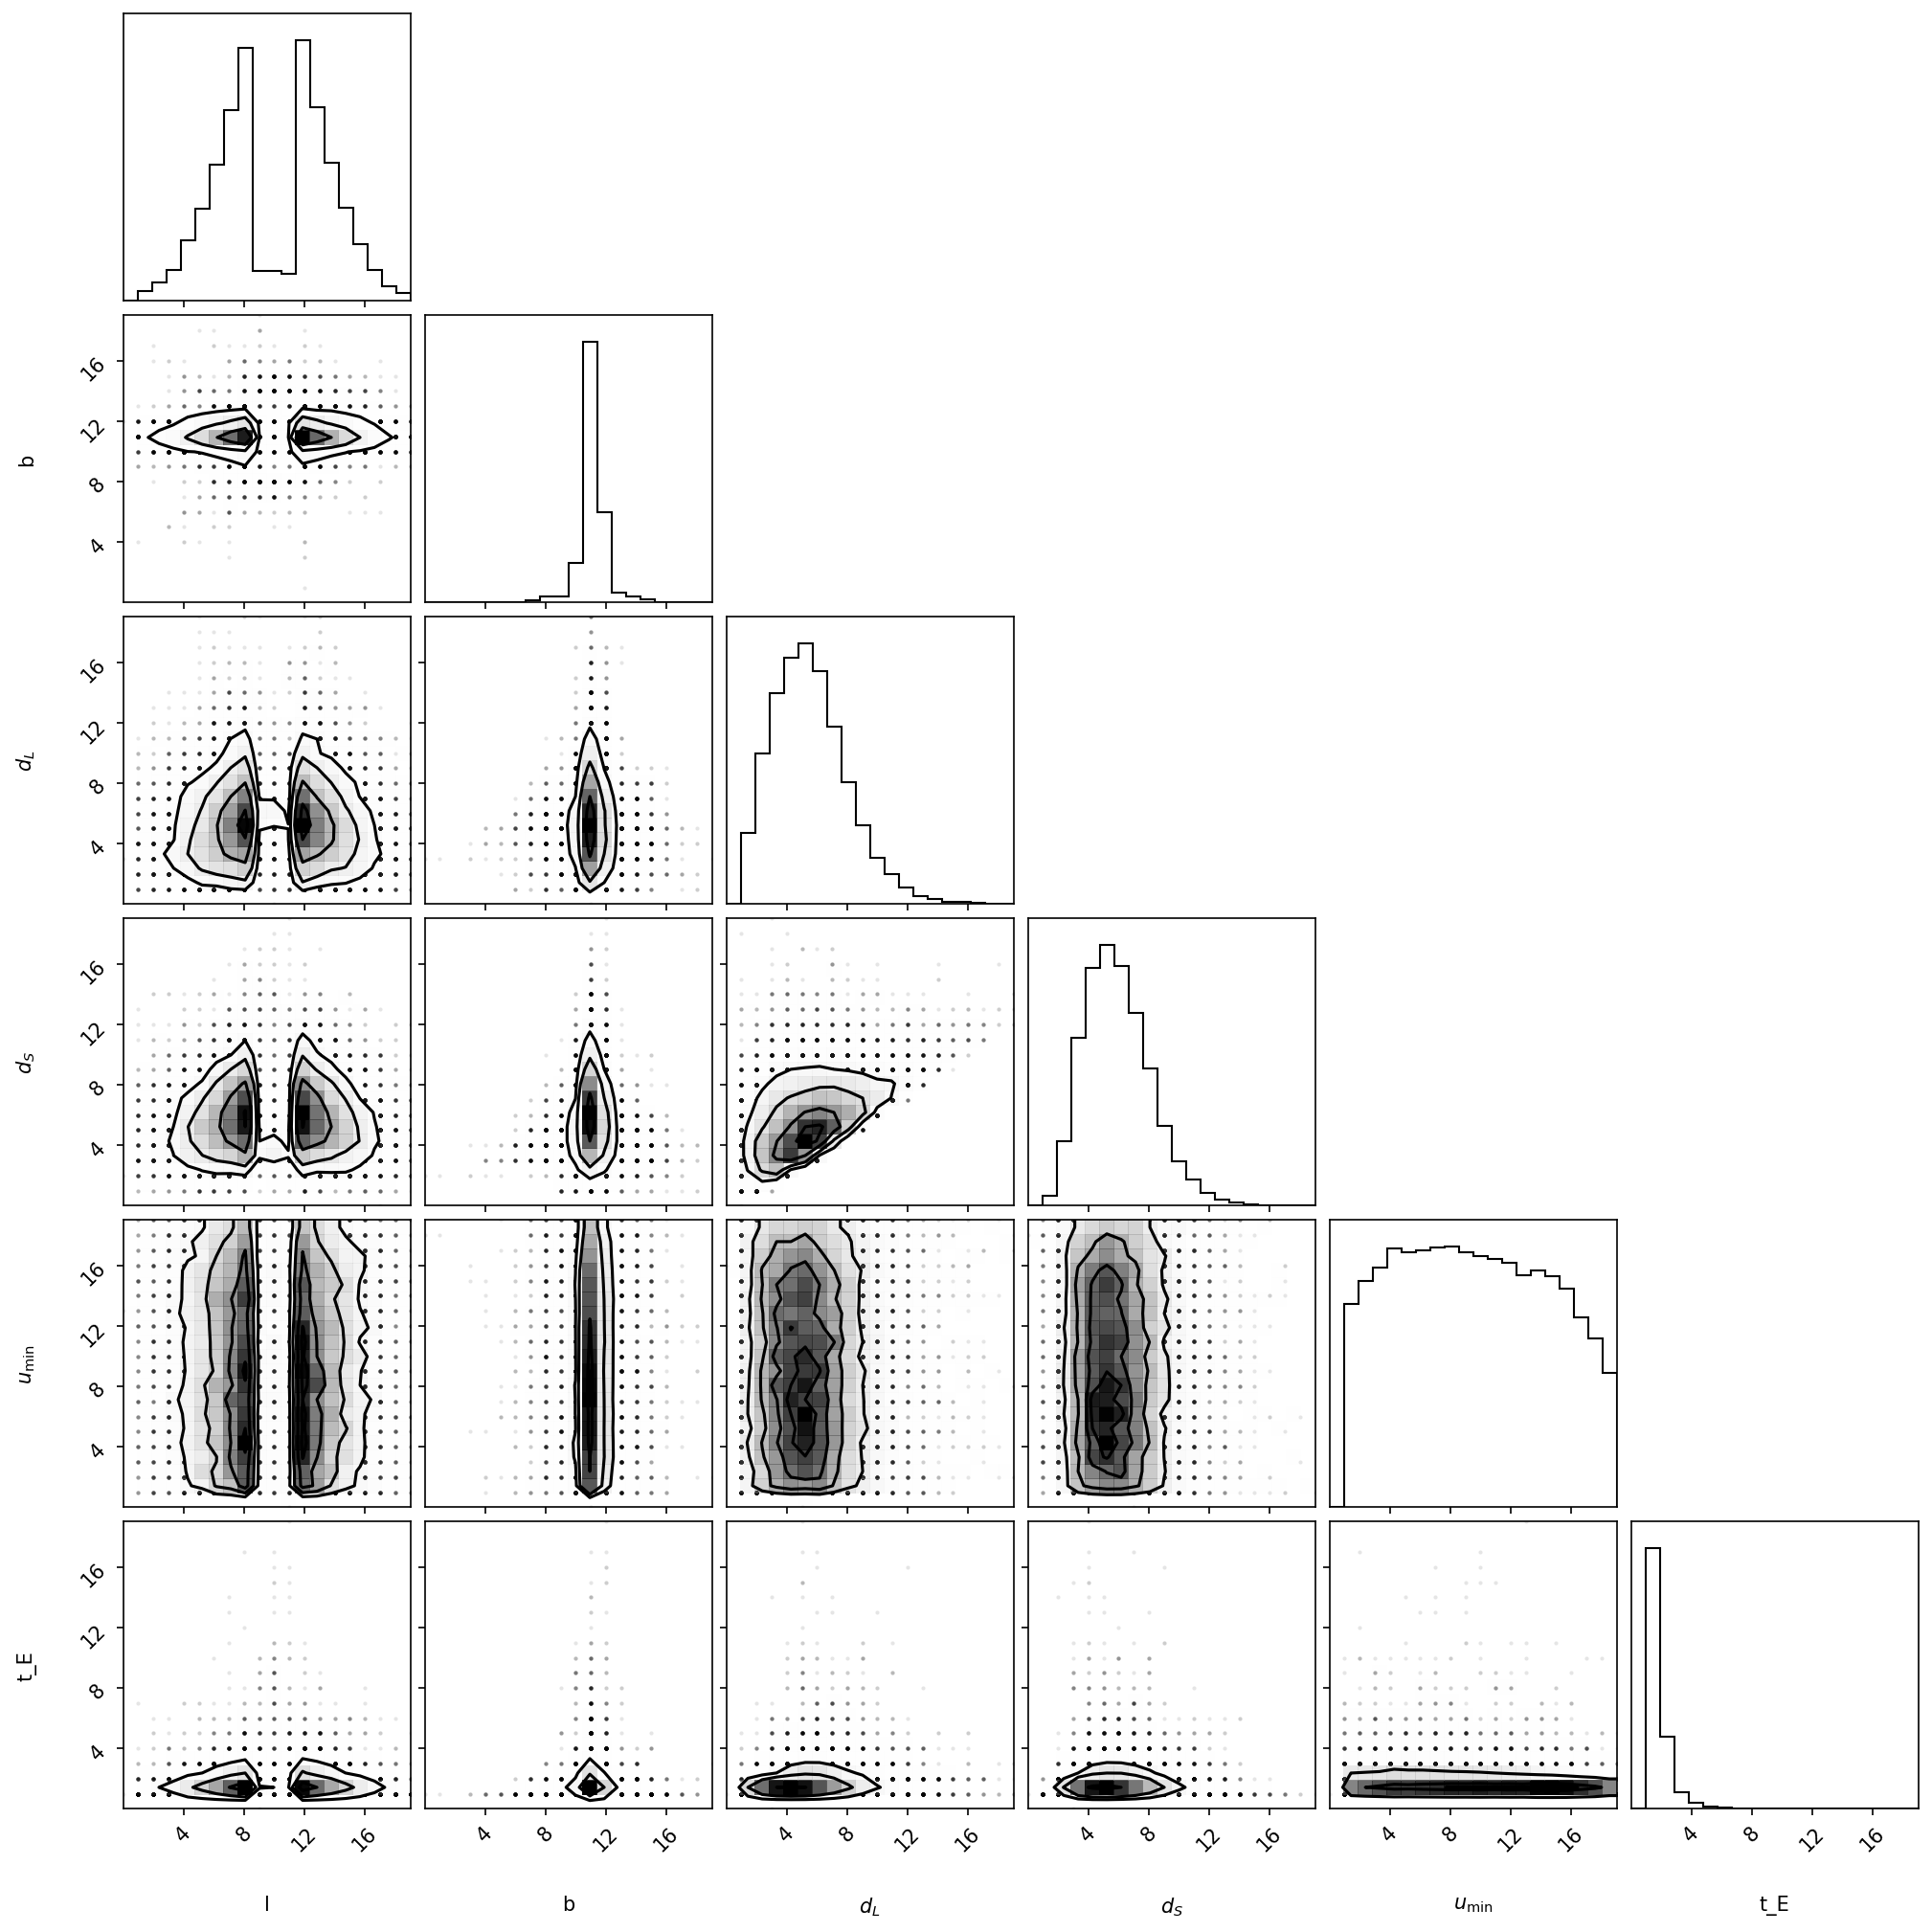

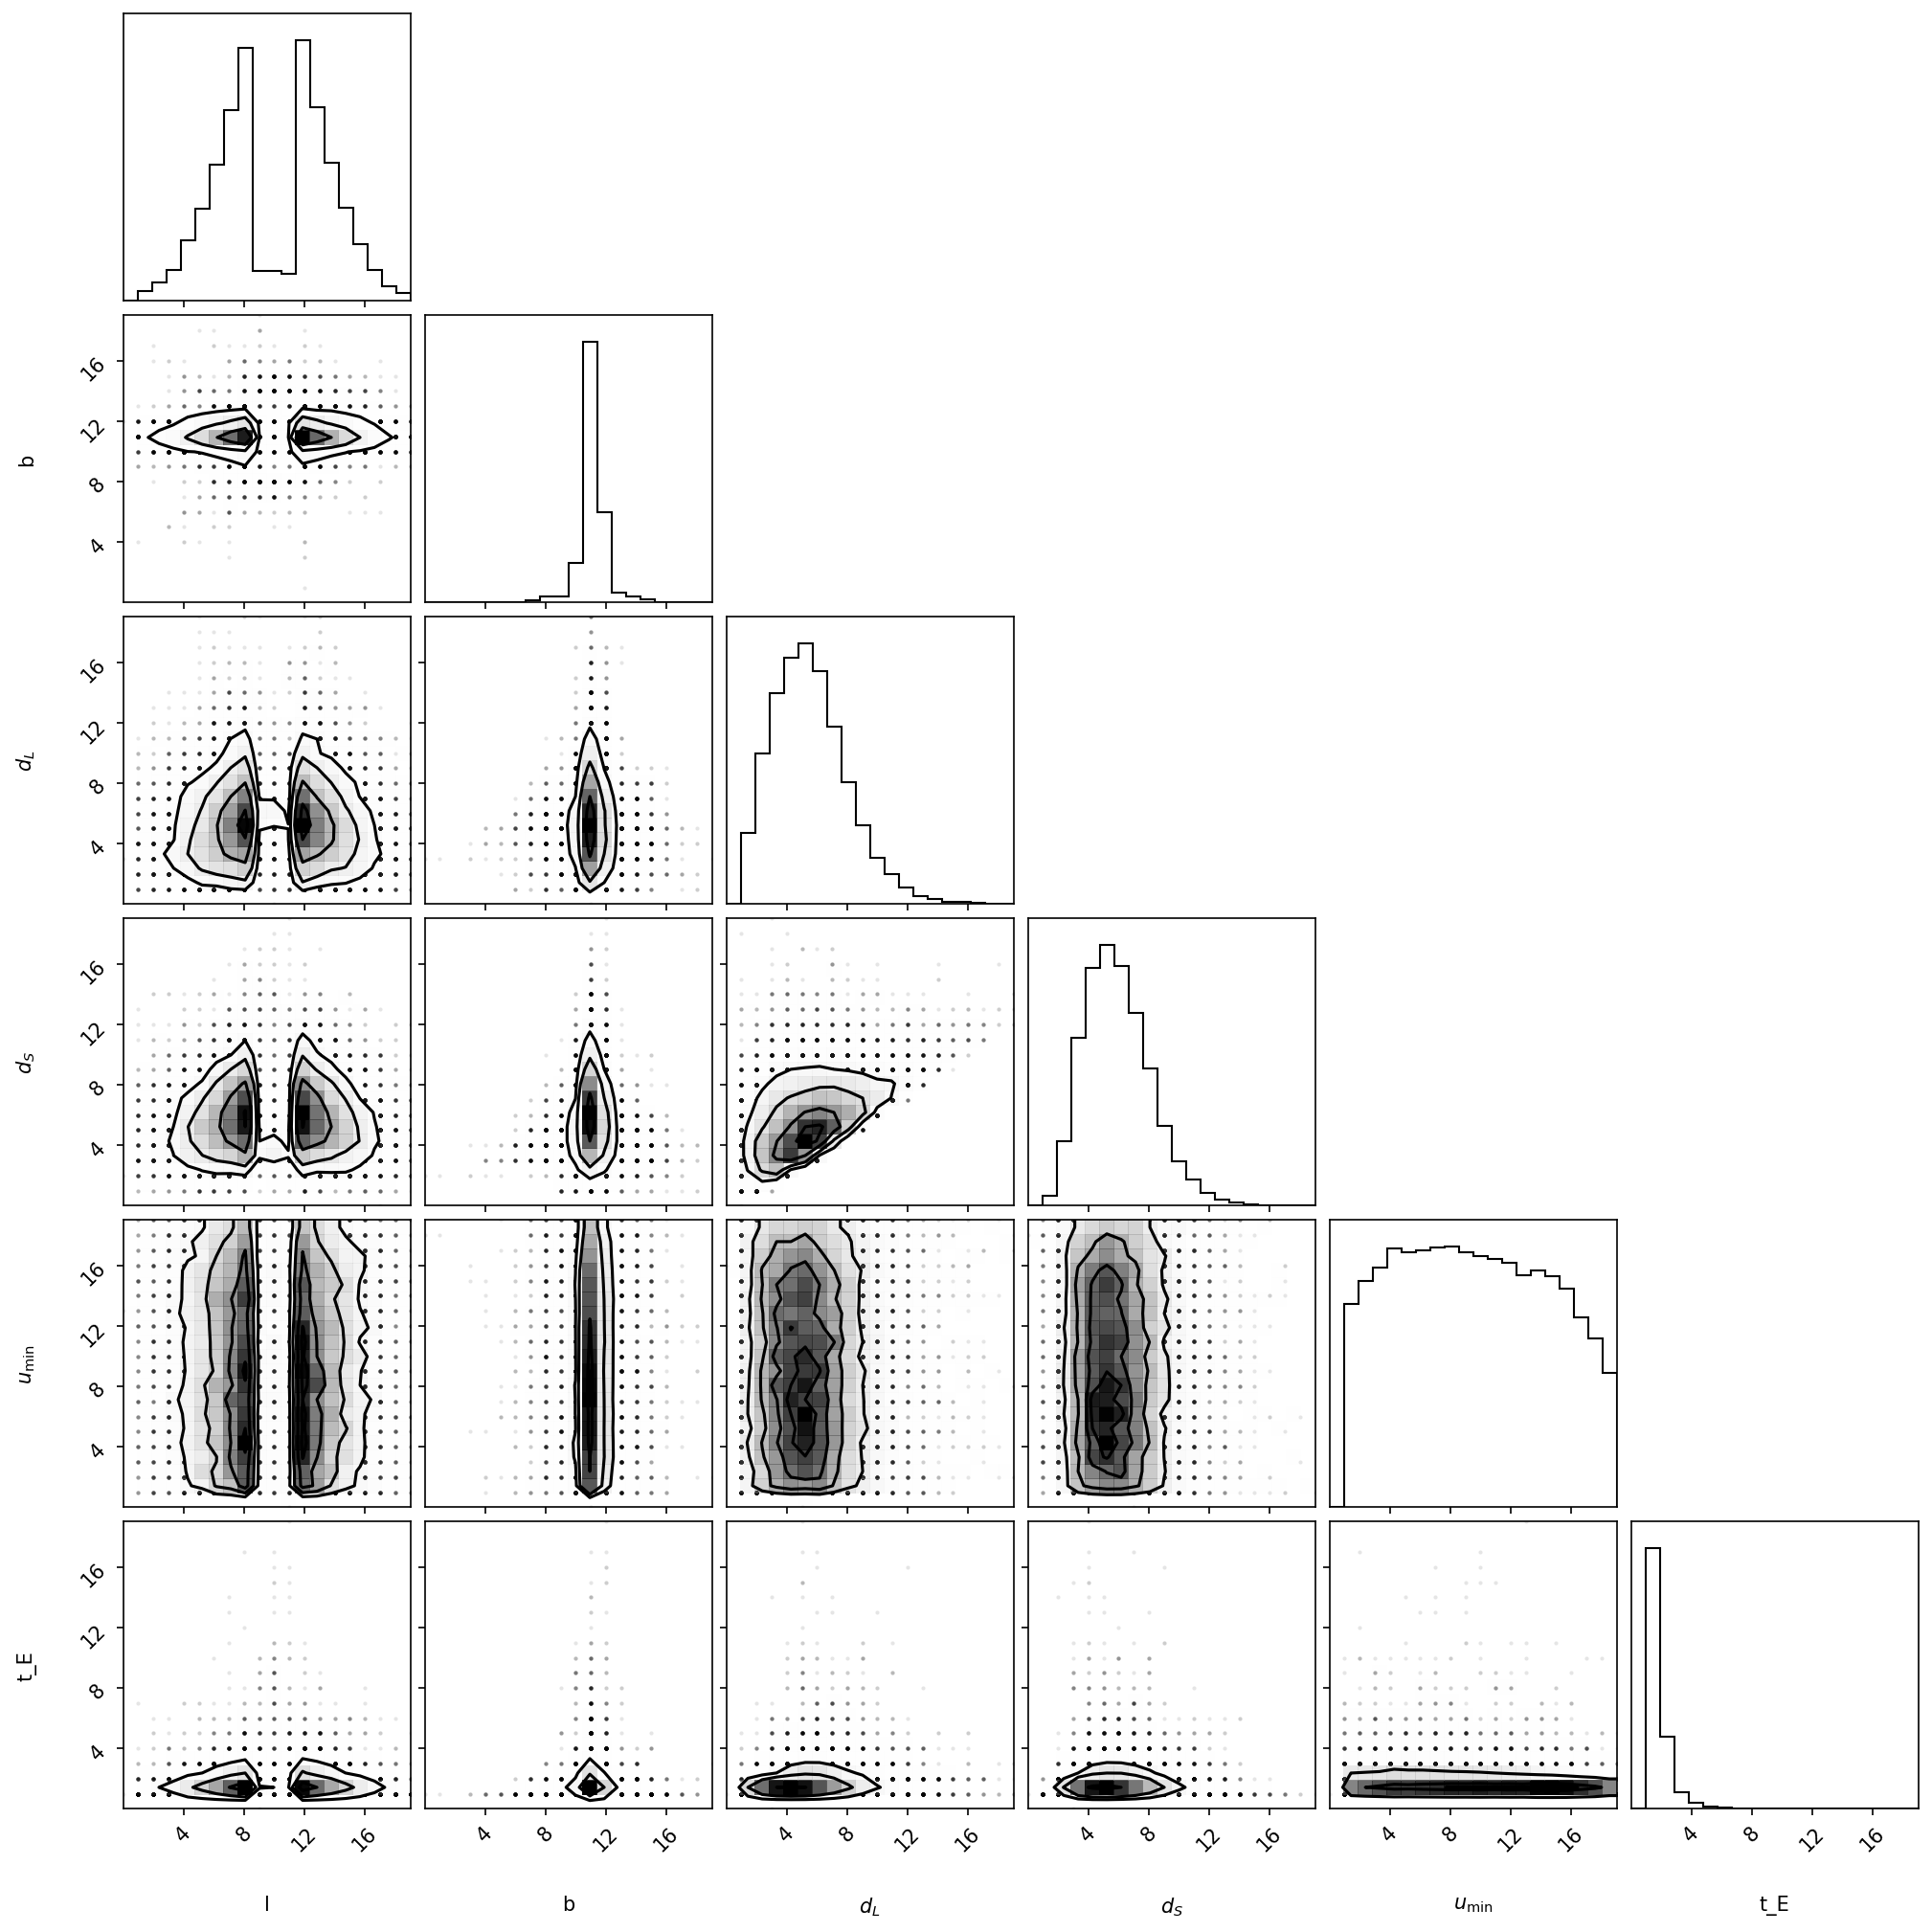

In [230]:
corner.corner(low_tail_bins,labels=['l','b',r'$d_L$',r'$d_S$',r'$u_\min$',r't_E'])

In [232]:
binned_rates_ratios_high_tail={}
for idx, ratio in binned_rates_ratios.items():
    if ratio/4>10**-5  :
        binned_rates_ratios_high_tail[idx] = ratio
high_tail_bins = np.array(list(binned_rates_ratios_high_tail.keys()))

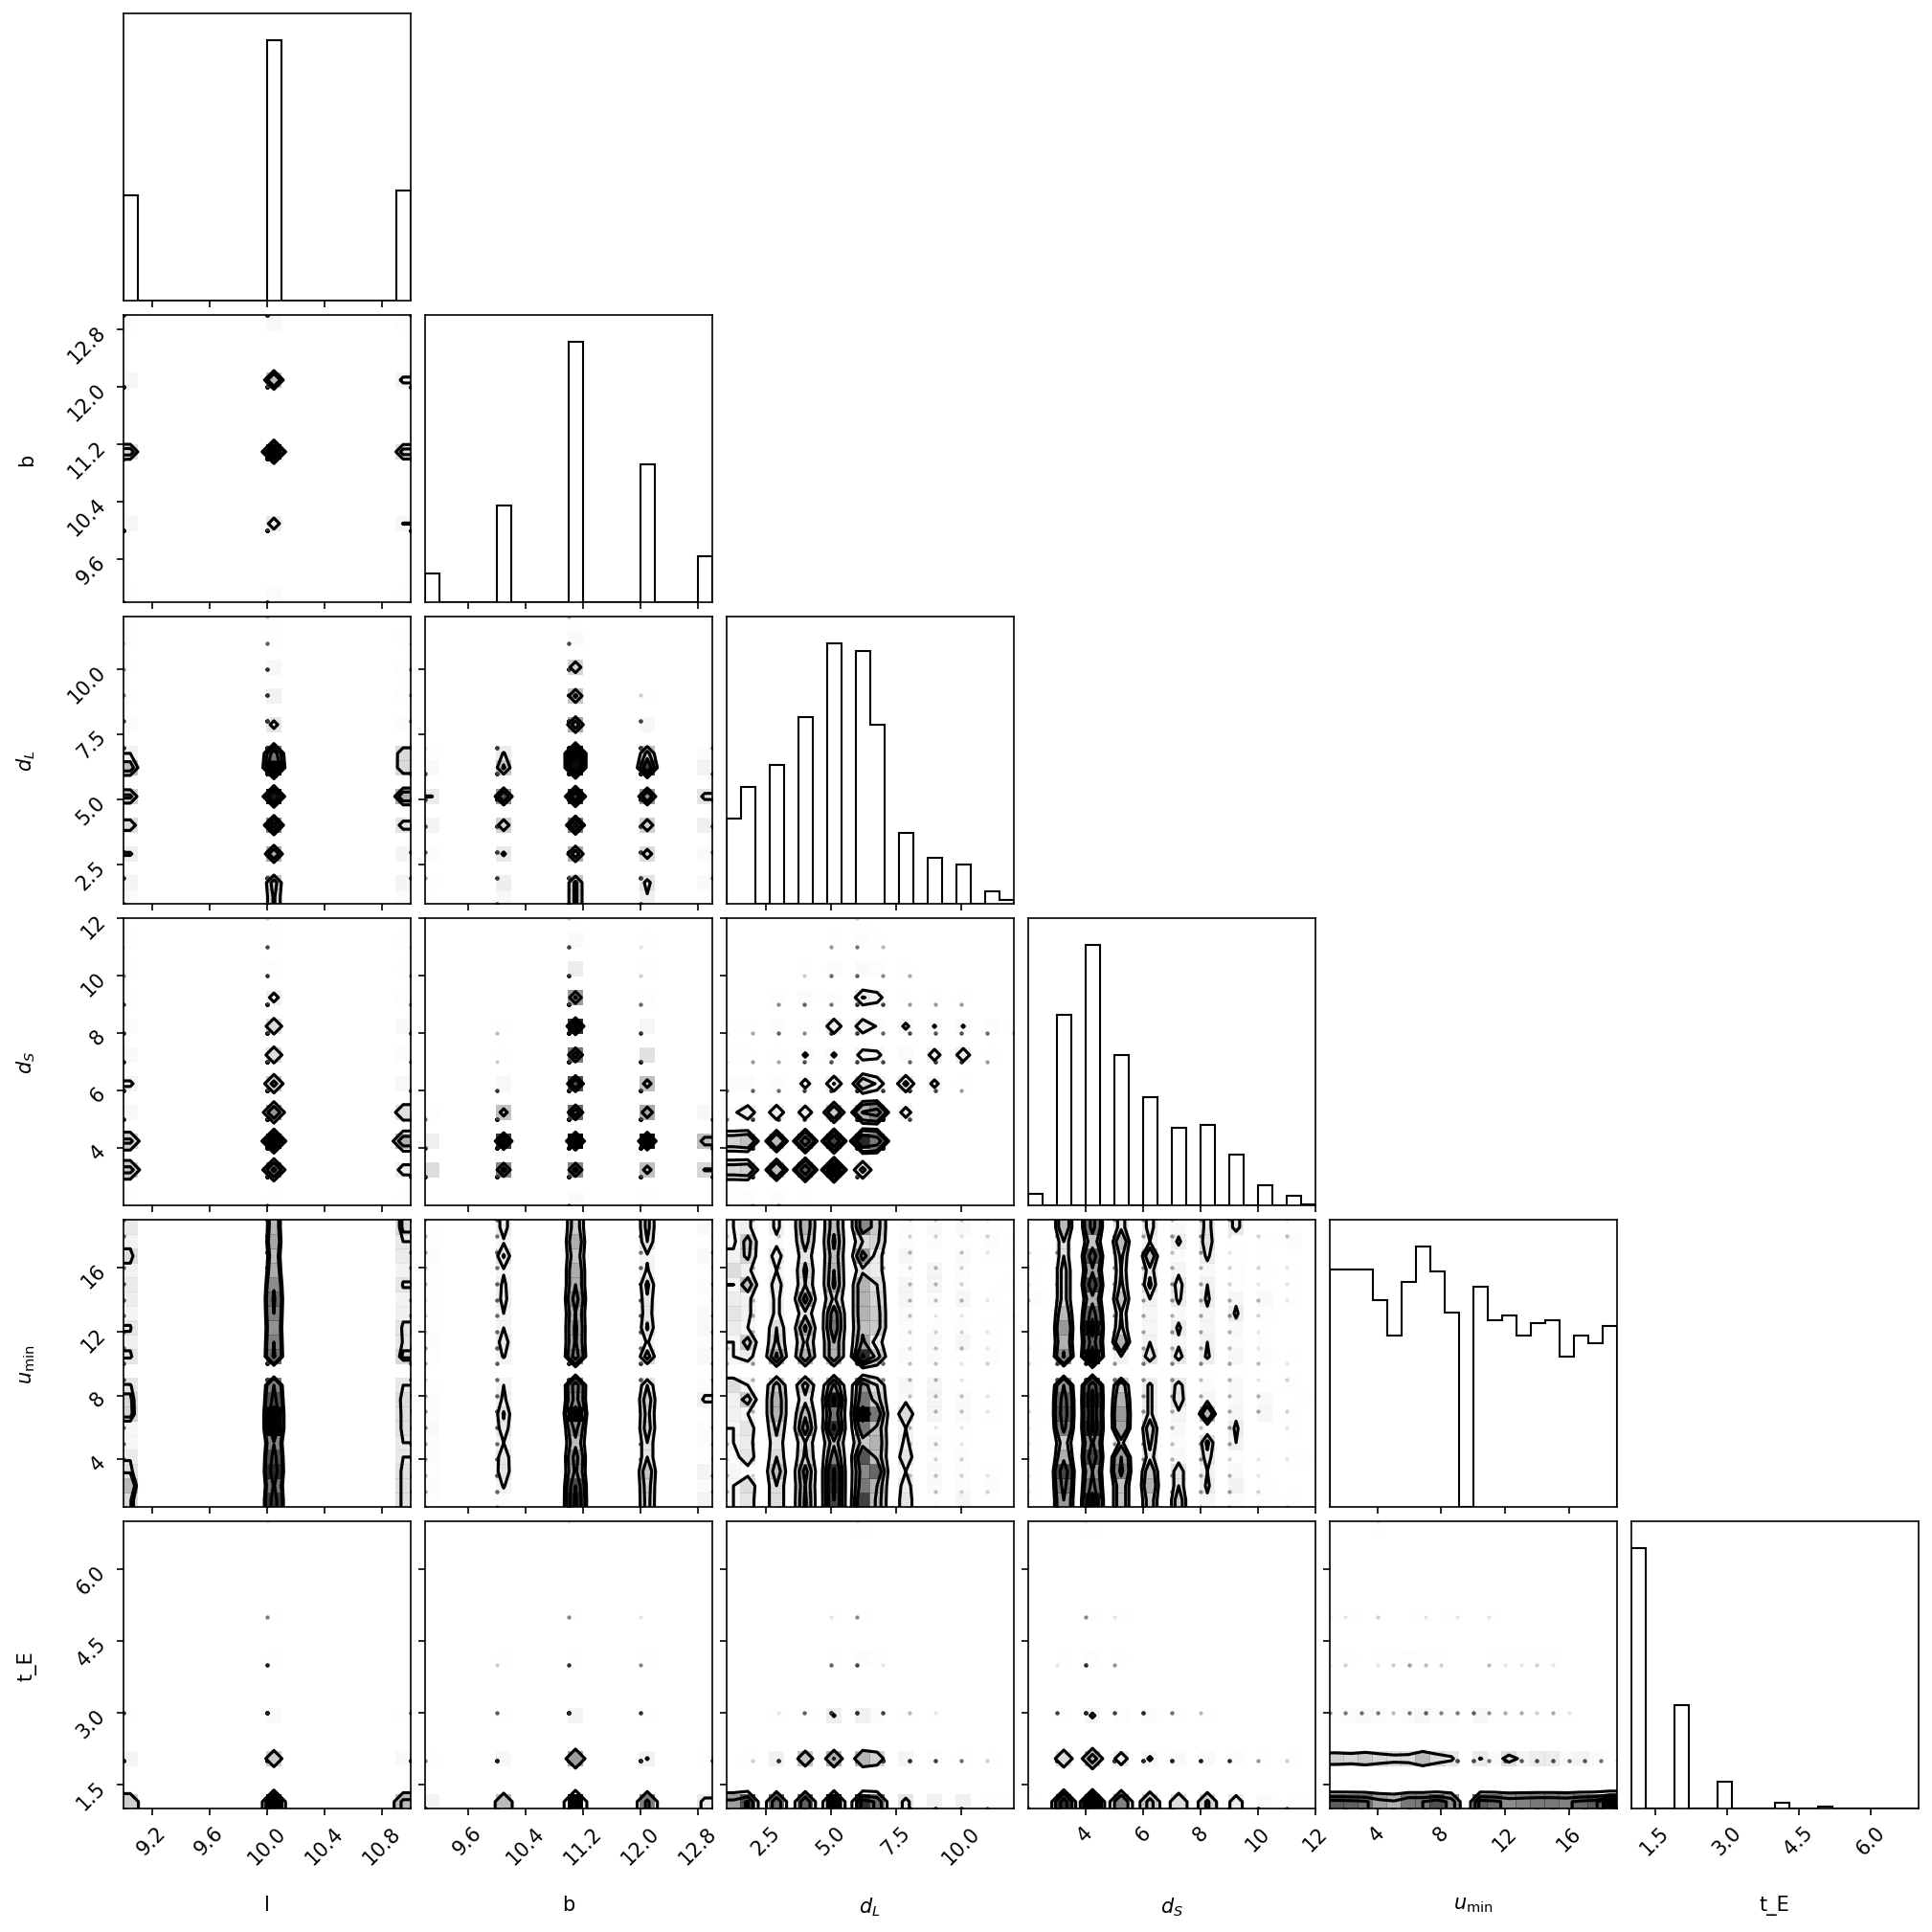

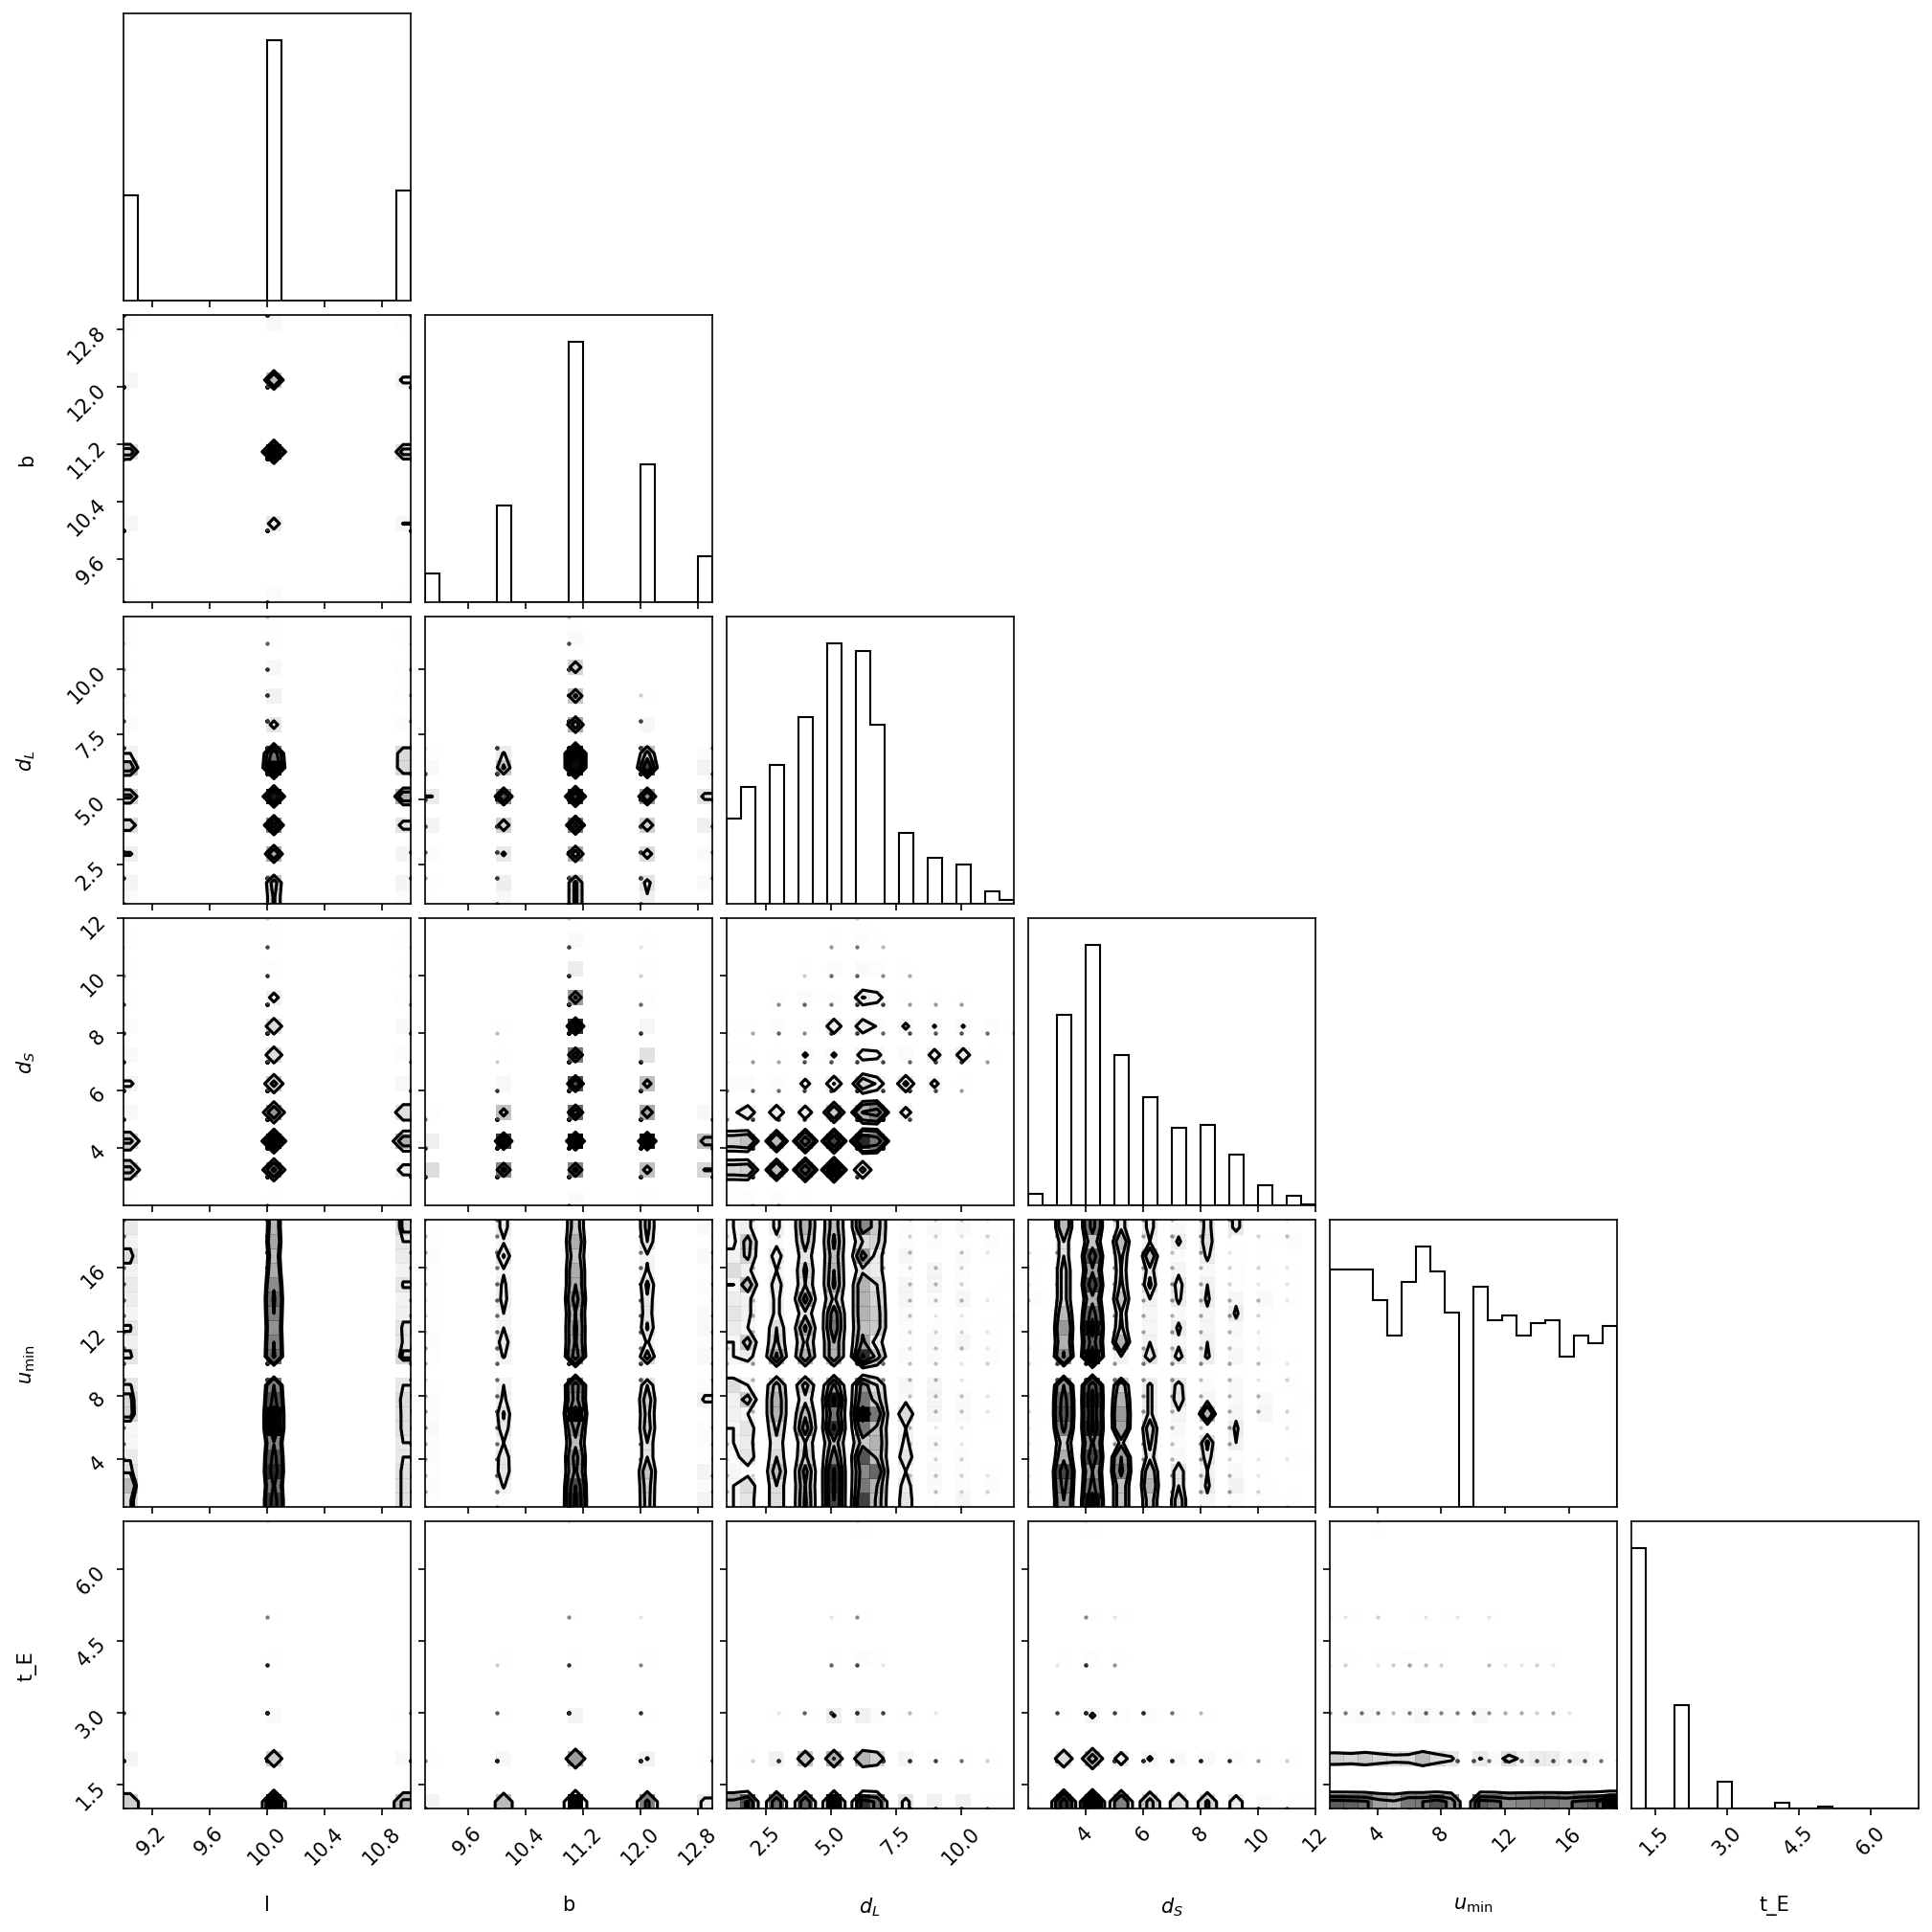

In [233]:
corner.corner(high_tail_bins,labels=['l','b',r'$d_L$',r'$d_S$',r'$u_\min$',r't_E'])

# where are the sparse bins?

In [288]:
binned_rates_ratios_sparse={}
nsparse=100
bulge_bins = coord_to_bin_indices(edges[:,:2], [0,0])
for idx, ratio in binned_rates_ratios.items():
    if binned_counts_dict[idx] < nsparse:
        binned_rates_ratios_sparse[idx] = ratio

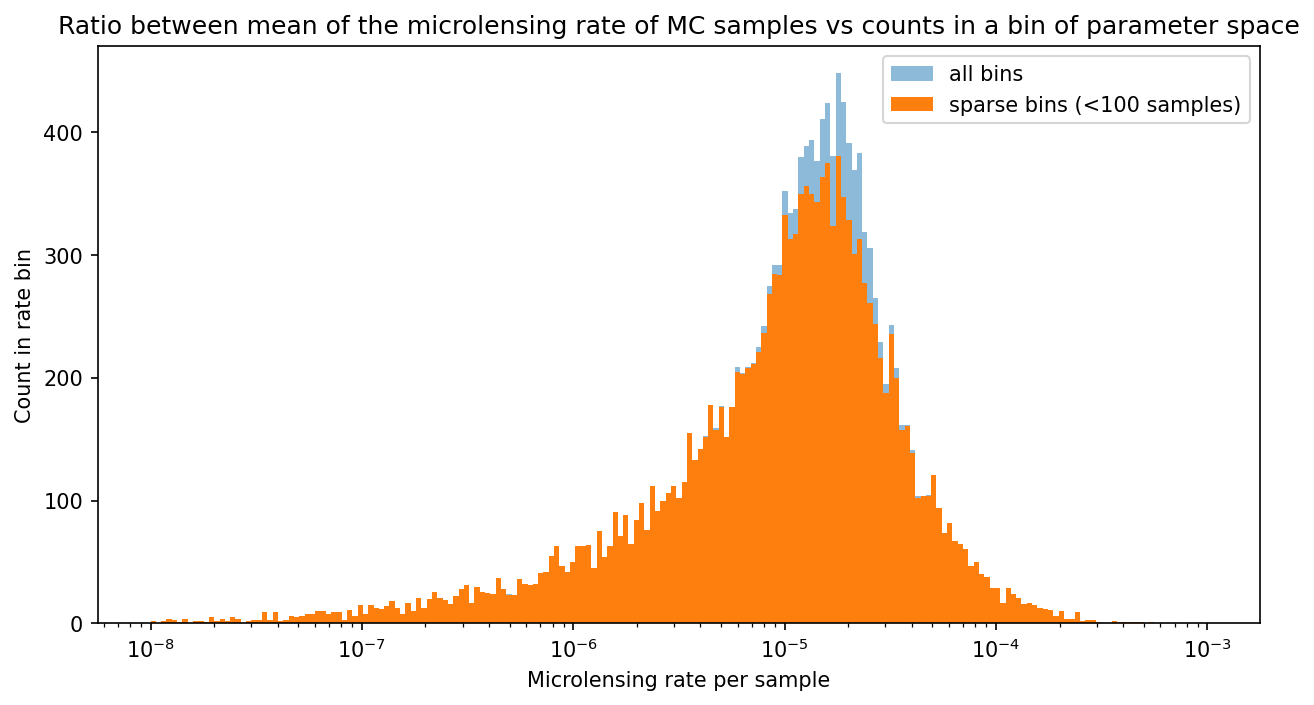

In [289]:
ratio_array_sparse=np.array(list(binned_rates_ratios_sparse.values()))

plt.hist(ratio_array,bins=np.logspace(-8,-3,200),label='all bins',alpha=.5)
plt.hist(ratio_array_sparse,bins=np.logspace(-8,-3,200),label=f'sparse bins (<{nsparse} samples)')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.legend()
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
plt.xscale('log')
#plt.yscale('log')

In [290]:
binned_rates_ratios_not_sparse = {idx: val for idx,val in binned_rates_ratios.items() if (idx not in binned_rates_ratios_sparse) }
ratio_array_not_sparse=np.array(list(binned_rates_ratios_not_sparse.values()))

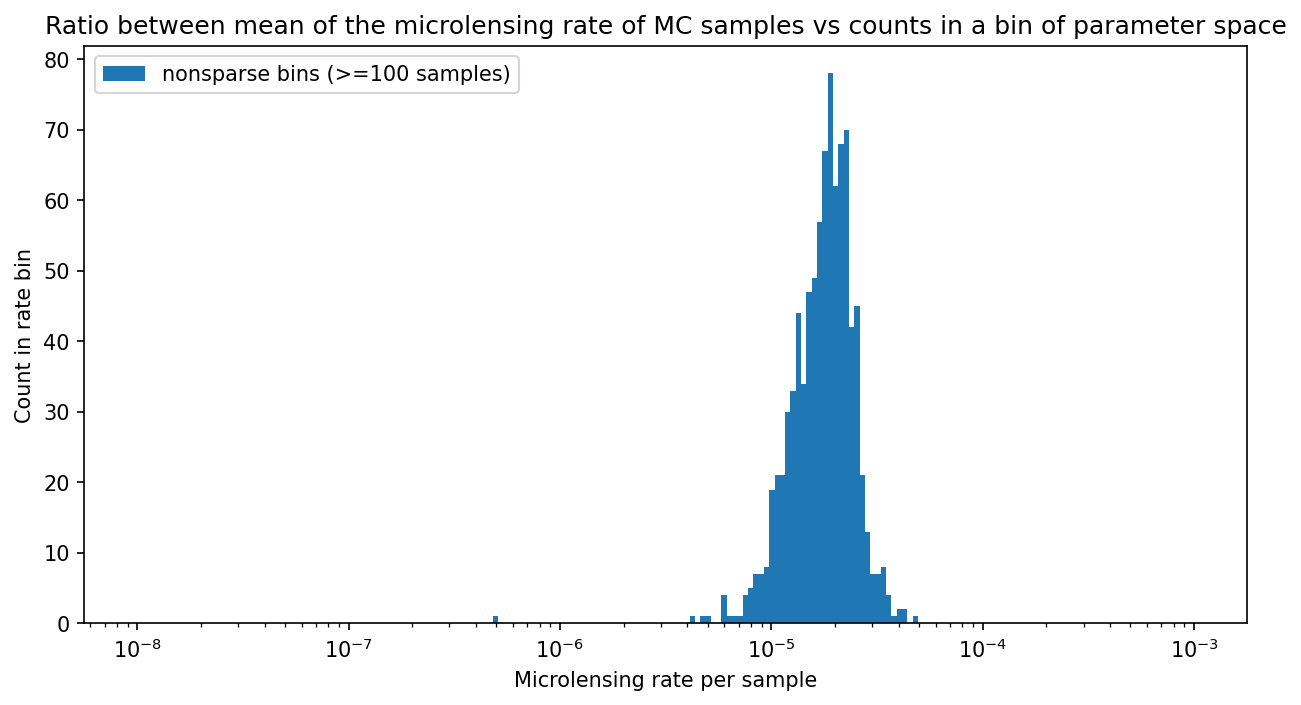

In [291]:
plt.hist(ratio_array_not_sparse,bins=np.logspace(-8,-3,200),label=fr'nonsparse bins (>={nsparse} samples)')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.legend()
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
plt.xscale('log')

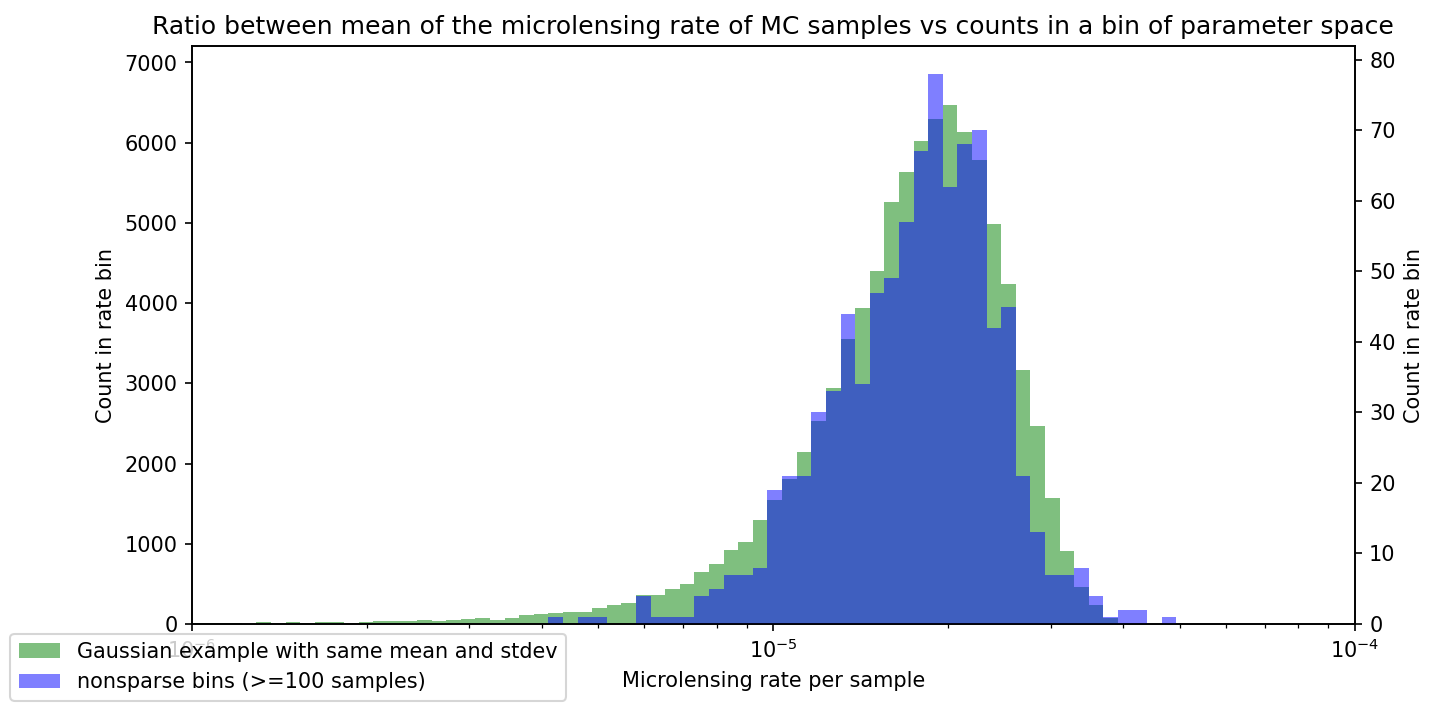

In [335]:
gauss_sample = np.random.normal(np.mean(ratio_array_not_sparse), np.std(ratio_array_not_sparse), size=100*len(ratio_array_not_sparse))
fig, ax1 = plt.subplots()
ax1.hist(gauss_sample,bins=np.logspace(-8,-3,200),label=fr'Gaussian example with same mean and stdev', alpha=.5,color='green')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
ax1.set_xlabel('Microlensing rate per sample')
ax1.set_ylabel('Count in rate bin')
ax1.set_xscale('log')
ax1.set_ylim(0,7200)

ax2 = ax1.twinx()
ax2.hist(ratio_array_not_sparse,bins=np.logspace(-8,-3,200),label=fr'nonsparse bins (>={nsparse} samples)',alpha=.5, color='blue')

ax2.set_xlabel('Microlensing rate per sample')
ax2.set_ylabel('Count in rate bin')
ax2.set_xscale('log')
ax2.set_xlim(10**-6, 10**-4)
fig.legend(loc='lower left')#['Gaussian example with same mean and stdev',fr'nonsparse bins (>={nsparse} samples)'])
#
plt.show()